# Putting the Change to the (A/B) Test...
An online store is trying to boost revenue. A list of hypotheses has been formulated, and we were asked to prioritize them and select one particular hypothesis to test, by means of an A/B test.

An A/B test has indeed been carried out, and we have received date about both control and test groups, spanning the entire month of August. It is our job to analyze the results and conclude whether the test should be continued or stopped, and if stopped - then why: does either group shows supremacy over the other, or are they the same, and there's no point in continuing it?

# Outline of Analysis
1) The first step will be to check the data, making sure there are no duplicates or other errors. Such errors could be that some user ID's have somehow been assigned to both the control and the test group, and therefore must be removed, as we can't know to which group they really belonged.

2) Using the list of hypotheses - where each one has values for different factors such as Reach, Impact, etc. - we will apply two different calculations (ICE and RICE) in order to estimate which ones are the most worthwhile to test using an A/B test. Should both calculations yield different results, we will try to explain the discrepencies.

3) The A/B test result analysis will take place by answering a series of questions, one by one. For each such question, a brief explanation of the steps about to be taken will be added. Finally, statistical tests will be performed on the raw data (raw, but does NOT include any removed data, as described in step 1 above), conclusions and/or conjectures following each finding.

4) We will search for outliers in order to determine anomalous behaviour (the definition of the latter will be given later). This will be done using the *entire* data, meaning, we are going to *ignore the division to groups* when looking for anomalous behaviour. Once found, those anomalies will be removed from the data (from both groups, of course), and we will re-run the statistical tests and checks on the now-filtered data, to see how patterns changed, considering only typical behaviours.

# Table of Contents
1. [Initialization](#Initialization)
2. [Hypothesis Prioritization](#Hypothesis-Prioritization)
3. [A/B Test Analysis](#A/B-Test-Analysis)
    
    3.1. [Graphic Representation of Cumulative Revenue by Group](#Graphic-Representation-of-Cumulative-Revenue-by-Group)
    
    3.2. [Graphic Representation of Cumulative Average Order Size by Group](#Graphic-Representation-of-Cumulative-Average-Order-Size-by-Group)
    
    3.3. [Graphic Representation of the Relative Difference in Cumulative Average Order Size](#Graphic-Representation-of-the-Relative-Difference-in-Cumulative-Average-Order-Size)
    
    3.4. [Graphic Representation of Each Group's Daily Conversion Rate](#Graphic-Representation-of-Each-Group's-Daily-Conversion-Rate)
    
    3.5. [Scatter Chart of the Number of Orders Per User](#Scatter-Chart-of-the-Number-of-Orders-Per-User)
    
    3.6. [Scatter Chart of the Order Sizes](#Scatter-Chart-of-the-Order-Sizes)
    
    3.7. [Finding the Statistical Significance of the Difference in Conversion Between the Groups Using the RAW Data](#Finding-the-Statistical-Significance-of-the-Difference-in-Conversion-Between-the-Groups-Using-the-RAW-Data)
    
    3.8. [Finding the Statistical Significance of the Difference in Average Order Size Between the Groups Using the RAW Data](#Finding-the-Statistical-Significance-of-the-Difference-in-Average-Order-Size-Between-the-Groups-Using-the-RAW-Data)

4. [Filtering the Data, Redrawing Graphs](#Filtering-the-Data,-Redrawing-Graphs.)

    4.1 [Graphic Representation of Cumulative Revenue by Group - Filtered Data](#Graphic-Representation-of-Cumulative-Revenue-by-Group---Filtered-Data)
    
    4.2 [Graphic Representation of Cumulative Average Order Size by Group - Filtered Data](#Graphic-Representation-of-Cumulative-Average-Order-Size-by-Group---Filtered-Data)
    
    4.3 [Graphic Representation of the Relative Difference in Cumulative Average Order Size - Filtered Data](#Graphic-Representation-of-the-Relative-Difference-in-Cumulative-Average-Order-Size---Filtered-Data)
    
    4.4 [Graphic Representation of Each Group's Daily Conversion Rate - Filtered Data](#Graphic-Representation-of-Each-Group's-Daily-Conversion-Rate---Filtered-Data)
    
    4.5 [Scatter Chart of the Order Sizes - Filtered Data](#Scatter-Chart-of-the-Order-Sizes---Filtered-Data)
    
    4.6. [Finding the Statistical Significance of the Difference in Conversion Between the Groups Using the FILTERED Data](#Finding-the-Statistical-Significance-of-the-Difference-in-Conversion-Between-the-Groups-Using-the-FILTERED-Data)
    
    4.7. [Finding the Statistical Significance of the Difference in Average Order Size Between the Groups Using the FILTERED Data](#Finding-the-Statistical-Significance-of-the-Difference-in-Average-Order-Size-Between-the-Groups-Using-the-FILTERED-Data)
    
5. [Decisions Based on the Results](#Decisions-Based-on-the-Results)

# Initialization

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import math
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# loading the data
# note: some of the datatypes have been optimized after careful examination of the original datatypes of each file.

hypotheses = pd.read_csv('hypotheses_us.csv', sep = ';')
orders_raw = pd.read_csv(
    'orders_us.csv',
    parse_dates=['date'],
    dtype = {'group' : 'category'} # only contains two possible values - 'A' or 'B'. no need for it to be 'object' type.
)
visits = pd.read_csv(
    'visits_us.csv',
    parse_dates=['date'],
    dtype = {'group' : 'category'} # same as in `orders_raw`.
)

In [3]:
# checking data info
pd.set_option('display.max_colwidth', None)
hypotheses.columns = hypotheses.columns.str.lower() # making column names all lowercase, for convenience.
hypotheses.info()
hypotheses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [4]:
orders_raw.info(memory_usage = 'deep')
orders_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 38.9 KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [5]:
# checking for duplicated rows
print ('Number of duplicated entries in "orders_raw":', orders_raw.duplicated().sum())

Number of duplicated entries in "orders_raw": 0


There are no duplicated entries. However, we still need to check if a particular `visitorId` has entries in which they belong to a DIFFERENT `group`. This will be considered an error, since each individual `visitorId` should belong to only one of the groups, not both.

We will make a list of the unique visitor ID's for each group. We will call them `members_a` and `members_b`. Then, we will make a `shared_members` list which is the intersection of the two, meaning, only ID's that appear on BOTH lists will make it to the `shared_members` list. We will use the latter to clear out all shared users from the `orders_raw` dataset. Just as a safety measure - we will name the clean dataset `orders`, and use only this one from that point forward.

In [6]:
members_a = orders_raw.query('group == "A"')['visitorId'].unique()
members_b = orders_raw.query('group == "B"')['visitorId'].unique()
shared_members = list(set(members_a).intersection(members_b))

print ('Amount of members in group A:', len(members_a))
print ('Amount of members in group B:', len(members_b))
print ('Amount of shared members:', len(shared_members))

Amount of members in group A: 503
Amount of members in group B: 586
Amount of shared members: 58


We can see that the two groups are not quite similar in size, but this is beyond our control. What we do see, is that 58 users belong into both groups, and thus must be removed from our data, prior to any analysis. Let's look at some more numbers:

In [7]:
print ("Amount of unique ID's in the original 'orders_raw' dataframe:", len(orders_raw['visitorId'].unique()))
print ('Percentage of shared users among all users: {:.2%}'.format(len(shared_members) / len(orders_raw['visitorId'].unique())))
print ("Expected amount of unique ID's after shared users removal:", len(orders_raw['visitorId'].unique()) - len(shared_members))

Amount of unique ID's in the original 'orders_raw' dataframe: 1031
Percentage of shared users among all users: 5.63%
Expected amount of unique ID's after shared users removal: 973


We will now filter the problematic ID's from `orders_raw` and make a new dataset, `orders`, in which we make sure we only have users belonging to a SINGLE group.

In [8]:
# filtering out shared members:
orders = orders_raw[~orders_raw['visitorId'].isin(shared_members)].reset_index()
orders.drop('index', axis = 1, inplace = True) # removing the redundant `index` column, which contains the old indices of the `orders_raw` table.

# checking the amount of unique users in the clean data - we expect it to be 973, according to the calculation above:
orders.info()
print ()
print ("Amount of unique ID's in the new 'orders' dataframe:", (len(orders['visitorId'].unique())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 33.0 KB

Amount of unique ID's in the new 'orders' dataframe: 973


Bingo. Now, just to be absolutely sure we have no shared users between groups, we will run the test again by creating two lists of unique users of each group (this will be quite similar to what we did before, with the `orders_raw` dataset):

In [9]:
members_a_new = orders.query('group == "A"')['visitorId'].unique()
members_b_new = orders.query('group == "B"')['visitorId'].unique()
shared_members_new = list(set(members_a_new).intersection(members_b_new))

print ('Amount of members in group A (new):', len(members_a_new))
print ('Amount of members in group B (new):', len(members_b_new))
print ('Amount of shared members (new):', len(shared_members_new))

Amount of members in group A (new): 445
Amount of members in group B (new): 528
Amount of shared members (new): 0


We're good now. Naturally, the amount of members in both groups is reduced by 58 each, since these are the shared ones.
Having got this out of the way, we can continue to checking the next dataset.

In [10]:
visits.info(memory_usage = 'deep')
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.3 KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
# checking for duplicated rows
print ('Number of duplicated entries in "visits":', visits.duplicated().sum())

Number of duplicated entries in "visits": 0


In [12]:
# checking that for each date, there is data for both groups:
control_visits = visits.query('group == "A"')
control_visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [13]:
test_visits = visits.query('group == "B"')
test_visits

,date,group,visits
31,2019-08-01,B,713
32,2019-08-02,B,581
33,2019-08-03,B,509
34,2019-08-04,B,770
35,2019-08-05,B,707
36,2019-08-06,B,655
37,2019-08-07,B,709
38,2019-08-08,B,654
39,2019-08-09,B,610
40,2019-08-10,B,369


This was a manual verification that both groups had data for the same dates. Manual, since the data spans only 1 month. We can see all days are accounted for.

Though it is not necessary, we could make an alternative dataframe for visits, which is just a merge of the above two. This could be useful if for some reason some dates had data for only one of the groups, but not both, and we would want to analyze only those dates with data for both:

In [14]:
# just for demonstration. the following dataframe will not be used in the analysis.
visits_alternative = control_visits[['date','visits']].merge(test_visits[['date','visits']], how = 'inner', on = 'date')
visits_alternative.columns = ['date', 'control_visits', 'test_visits']
visits_alternative

,date,control_visits,test_visits
0,2019-08-01,719,713
1,2019-08-02,619,581
2,2019-08-03,507,509
3,2019-08-04,717,770
4,2019-08-05,756,707
5,2019-08-06,667,655
6,2019-08-07,644,709
7,2019-08-08,610,654
8,2019-08-09,617,610
9,2019-08-10,406,369


The `visits` dataset looks good. No duplicate nor null values.

One might wonder if the values in `visits` column include visits from the shared users we have just removed from the `orders_raw` dataframe. It is reasonable that they do, but unfortunately there is nothing we can do about it, since the `visits` is only a summary of visit amounts per date, per group (aggregated data). In other words, the dataset does not give any information about WHO (which visitorId) visited from each group, in which date, and how many times, so we cannot remove them. This means our data **may be inaccurate**. However, again, there is nothing we can do about it right now.

This concludes the initialization step. We will now begin the analysis.

# Hypothesis Prioritization
We have a total of nine hypotheses which we need to prioritize. We will apply two methods for ranking those hypotheses numerically - ICE and RICE. 

It's worth to mention, though, that some people might argue that the selection of an hypothesis to be tested should not be exclusively based on numerical values (which might even be semi-arbitrary), but should also be based on common sense and logical thinking. Having said that, in this project we will have to base our selection only on numerical rankings.

The ICE method takes into account three properties of a given hypothesis - Impact, Confidence, and Ease/Effort (thus the acronym ICE). 

RICE is just a modified version of ICE, taking into account one additional factor - Reach.

More on all of those later. For now, since we have no data on *Ease* of an hypothesis, only *Effort*, we will use the following formulas to rank the hypotheses:

ICE Score= (Impact * Confidence) / Effort

RICE Score = (Reach * Impact * Confidence) / Effort

Our `hypotheses` dataframe contains numerical values for all of the above properties, on a scale from 1-10. We will now apply the above formulas and add corresponding columns to the `hypothesis` dataframe.

In [15]:
hypotheses['ICE_score'] = ((hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']).round(decimals = 1)
hypotheses['RICE_score'] = ((hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']).round(decimals = 1)

In [16]:
# hypotheses rank by ICE score, in descending order:
hypotheses[['hypothesis', 'ICE_score']].sort_values(by = 'ICE_score', ascending = False)

,hypothesis,ICE_score
8,Launch a promotion that gives users discounts on their birthdays,16.2
0,Add two new channels for attracting traffic. This will bring 30% more users,13.3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.2
6,Show banners with current offers and sales on the main page. This will boost conversion,8.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.0
1,Launch your own delivery service. This will shorten delivery time,2.0
5,Add a customer review page. This will increase the number of orders,1.3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.1
4,Change the background color on the main page. This will increase user engagement,1.0


In [17]:
# hypotheses rank by RICE score, in descending order:
hypotheses[['hypothesis', 'RICE_score']].sort_values(by = 'RICE_score', ascending = False)

,hypothesis,RICE_score
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


We can see how different definitions of prioritization can affect the ranks of different hypotheses, since the rankings are quite different between the two methods.

The main (and perhaps, only) reason the rankings differ in both methods is simply the fact that while RICE considers all the factors that ICE does, the former takes into account a fourth factor - REACH, which basically means "how many users will be affected if we change X". A score of 10 in `Reach` can mean, for example, that 100% of users will be affected (it depends how we define the `Reach` score), meaning everyone will be affected by the change, but, as opposed to `Impact` - it doesn't tell us **how strongly** those users will be affected. Is the effect only slight (low impact)? or is it a major effect (high impact)?

In other words, the RICE score is the same as ICE, but it is multiplied by a user-exposure coefficient. This means that a certain hypothesis can be about a new feature that affects the RELEVANT users greatly (high impact), but the AMOUNT of those relevant users is very low (meaning, low reach). This would make this hypothesis very tempting to test if we judge it by its ICE score, but not so much if we judge it by its RICE score.

For example, let's look at the hypothesis with index 8. Its ICE score is the highest, as it has a very high `Impact` and `Confidence` levels, but it is only 5th place in terms of the RICE score, becuase its `Reach` parameter is only 1, which would suggest it might be less worthwhile to examine. The hypothesis with index 7, which has a similar `Effort` level as hypothesis 8, is only 3rd place in the ICE ranking, but due to extremely high `Reach` parameter (10), it leads the RICE chart by a significant margin. Though it has slighly lower values for `Impact` and `Confidence`, its USER-EXPOSURE is what makes all the difference. 

# A/B Test Analysis
After a specific A/B test has been carried out, it's time to analyze its results. Note: we do not know what kind of test it was, and/or what hypothesis has been tested. This part is unrelated to the previous one.

Each step of the analysis below will be accompanied by a brief explanation of what is going to be done, as well as conclusions and conjectures.

## Graphic Representation of Cumulative Revenue by Group
This is what we will do:

1) Split the `orders` table into two separate tables - one for the control group (A) and one for the test group (B). 

2) For each group a new table will be made, with the total revenue in each day.

3) A new column - `cumulative_revenue` will be made.

4) Both groups' cumulative revenues will be plotted on a single chart.

In [18]:
# creating a slice of the control group's cumulative orders by date:
orders_control = orders.query('group == "A"')
control_data = orders_control.groupby(orders_control['date'])['revenue'].sum().reset_index()
control_data['cumulative_revenue'] = control_data['revenue'].cumsum()

# doing the same for the test group's orders:
orders_test = orders.query('group == "B"')
test_data = orders_test.groupby(orders_test['date'])['revenue'].sum().reset_index()
test_data['cumulative_revenue'] = test_data['revenue'].cumsum()

In [19]:
# checking the result for one of the tables:
test_data.head()

,date,revenue,cumulative_revenue
0,2019-08-01,967.2,967.2
1,2019-08-02,2568.1,3535.3
2,2019-08-03,1071.6,4606.9
3,2019-08-04,1531.6,6138.5
4,2019-08-05,1449.3,7587.8


In [ ]:
# plotting the graph:
pio.templates.default = "plotly_dark" # setting the theme to dark, personal preference.

fig = go.Figure()
fig.add_trace(go.Scatter(x=control_data['date'], 
                         y=control_data['cumulative_revenue'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_data['date'], 
                         y=test_data['cumulative_revenue'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Cumulative Revenue Comparison',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Cumulative Revenue', tickprefix = '$')

fig.show()

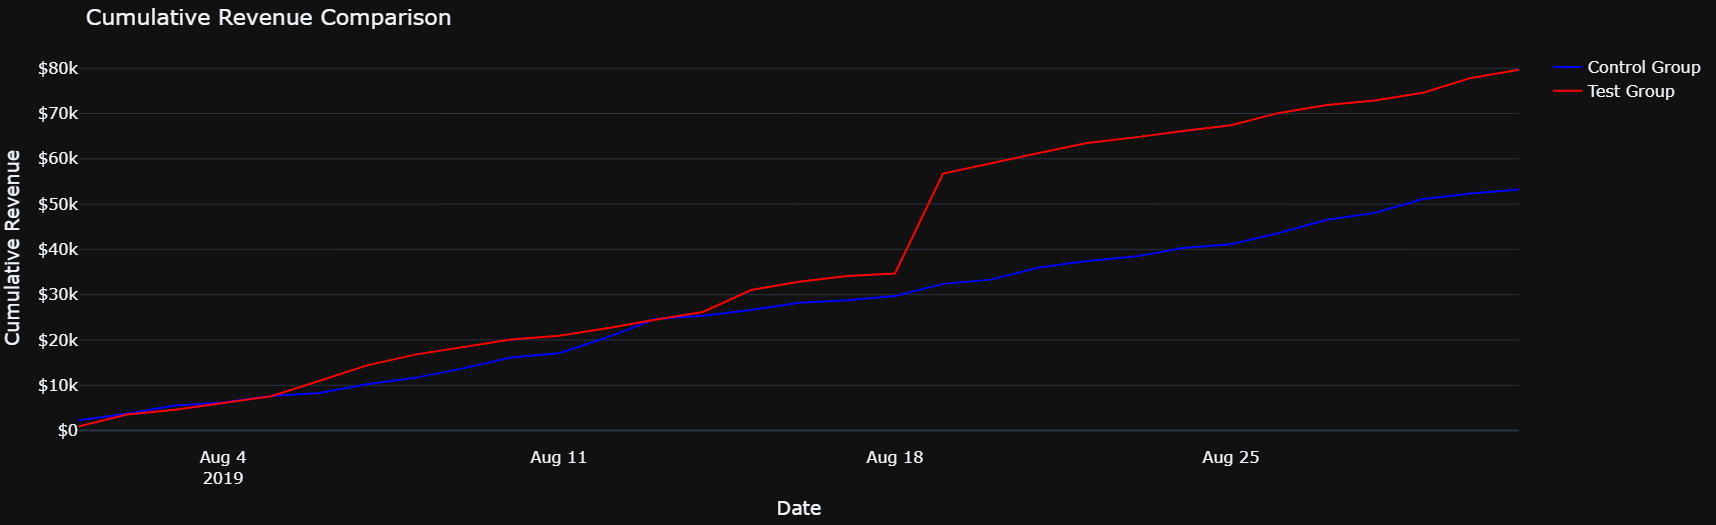

At the beginning of the test (the first few days), the two groups showed similar behaviour. After that, from August 5th, the test group (red) has demonstrated a slightly greater rise in cumulative revenue, but the control group (blue) closed the gap on August 13th. Then, the test group opened a new gap, and on August 19th there was a "spike" in its cumulative revenue, making the gap even larger. After that, the two groups behaved quite similarly, meaning the cumulative revenues continued to grow at approximately the same rate each day.

Basically, if we ignore the revenue spike on August 19th, we could say that the two groups behave rather similarly, with a **slight advantage for the test group.** Though the first gap (from August 5th) was closed by the control group, the graph suggests that without the spike of August 19th, the test group would probably have maintained a constant advantage (difference in cumulative revenue) over the control group, beginning at the middle of the month, seeing as the lines have approximately similar slopes.

We will need to see what exactly happened on August 19th that caused this spike - it could be an outlier, rather than the general behaviour of the test group. The general behaviour would probably result in a more gradual increase of the gap over the control group over time, rather than a single-day "bump" in revenues. 

This would of course mean that the test group performs bettwe than the control group, but this will have to be checked and verified (and it will!)

## Graphic Representation of Cumulative Average Order Size by Group
This is what we will do:

1) From each group's respective `orders` table, we will create a new (temporary) aggregated table, in which we will have a column that counts the exact `number_of_orders` each group had, in each day.

2) We will add this `number_of_orders` column to the corresponding `data` tables we created earlier (`control_data` and `test_data`), and will add the following columns:

`cumulative_number_of_orders`, which is self-explanatory;

`cumulative_average_order_size`, which is the cumulative revenue divided by the cumulative number of orders.

The latter column will show us how the (cumulative) average order size has changed during the test.

3) Both groups' cumulative average order sizes will be plotted, similarly to what we did in the previous part.

In [21]:
# creating the temporary aggregated tables:
control_number_of_orders = orders_control.groupby(orders_control['date']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

test_number_of_orders = orders_test.groupby(orders_test['date']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

# adding the `number_of_orders` column from the above tables to the corresponding data tables from before:
control_data['number_of_orders'] = control_number_of_orders['number_of_orders']
test_data['number_of_orders'] = test_number_of_orders['number_of_orders']

# adding the additional columns described above:
control_data['cumulative_number_of_orders'] = control_data['number_of_orders'].cumsum()
control_data['cumulative_average_order_size'] = (control_data['cumulative_revenue'] / control_data['cumulative_number_of_orders']).round(decimals = 1)

test_data['cumulative_number_of_orders'] = test_data['number_of_orders'].cumsum()
test_data['cumulative_average_order_size'] = (test_data['cumulative_revenue'] / test_data['cumulative_number_of_orders']).round(decimals = 1)

In [22]:
# checking the result for one of the tables:
test_data.head()

,date,revenue,cumulative_revenue,number_of_orders,cumulative_number_of_orders,cumulative_average_order_size
0,2019-08-01,967.2,967.2,17,17,56.9
1,2019-08-02,2568.1,3535.3,23,40,88.4
2,2019-08-03,1071.6,4606.9,14,54,85.3
3,2019-08-04,1531.6,6138.5,14,68,90.3
4,2019-08-05,1449.3,7587.8,21,89,85.3


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=control_data['date'], 
                         y=control_data['cumulative_average_order_size'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_data['date'], 
                         y=test_data['cumulative_average_order_size'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Cumulative Average Order Size Comparison',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Cumulative Average Order Size', tickprefix = '$')

fig.show()

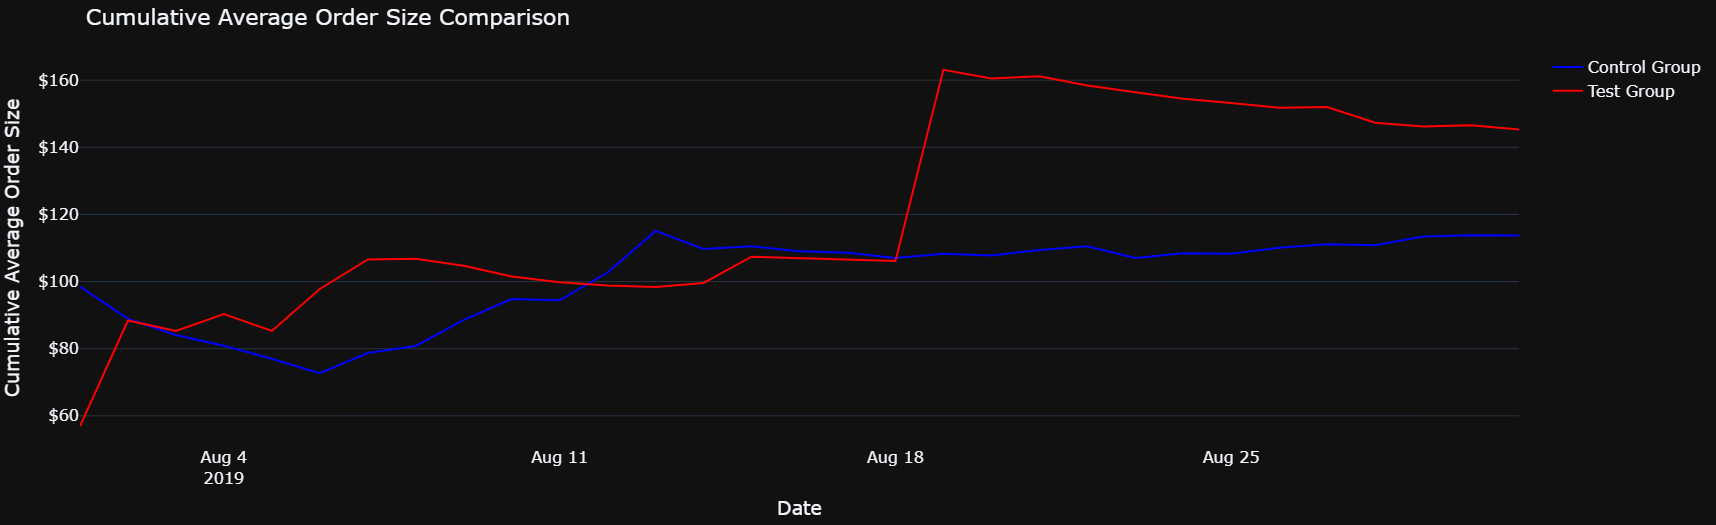

For the control group (blue), we see an initial decrease of the cumulative average order size, until August 6th. Then it increases significantly over a period of a week, decreases slightly and stablizes around ~110 dollars.

For the test group (red), we see a general increase in the cumulative average order size up until August 7th (to ~110 USD), and it is maintained around that level until August 18th (slightly decreasing and then increasing back to the same level). Now-unsurprisingly, There is yet another "bump" in the metric on August 19th, due to our suspected outlier, as the average order size now increased by 57 USD in a single day. After that day, the graph steadily decreases - which actually supports the assumption that what happened on August 19th was an outlier - one (or a few) major orders which bumped the average order size for the test group - but since this abnormal behaviour did not occur again afterwards (probably, only group-normal purchases were made from that point), the average slowly decreases back to a more realistic level. It is plausible that given more time, the red graph would continue to decrease and finally stabilize around the test group's REAL cumulative average order size, whatever that may be.

Once again, we will need to see what happens after we find (and remove) the suspected outlier from the test group (and we will, later). It is likely that the graph will either maintain its stabilized trend OR begin to increase/decrease *gradually* due to the normal behaviour of the test group. Whatever we may see, it is now even more clear that what we see currently is NOT the true effect of the change made to the product/website.

## Graphic Representation of the Relative Difference in Cumulative Average Order Size 

In order to see the difference between the two groups in an alternative (and usually more obvious way), we will create a small table containing the dates, the cumulative average order size of both groups, and another column in which the following is calculated:

`relative_difference` = (test group's cumulative average order size / control group's cumulative average order size) - 1

We substract 1 from the division so in case the two metrics are identical, the result would be 0, meaning - "no relative difference".

We will then plot this column.

In [24]:
# creating the relevant table
relative_difference = pd.merge(
    control_data['cumulative_average_order_size'], 
    test_data['cumulative_average_order_size'], 
    how = "inner", 
    on = control_data['date'])
relative_difference.columns = ['date', 'control_group', 'test_group'] # remember - the last two columns contain the respective group's cumulative average order size!
relative_difference['relative_difference'] = (relative_difference['test_group'] / relative_difference['control_group']) - 1

relative_difference.head()

,date,control_group,test_group,relative_difference
0,2019-08-01,98.5,56.9,-0.422335
1,2019-08-02,88.9,88.4,-0.005624
2,2019-08-03,84.1,85.3,0.014269
3,2019-08-04,80.9,90.3,0.116193
4,2019-08-05,77.0,85.3,0.107792


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=relative_difference['date'], 
                         y=relative_difference['relative_difference'],
                         mode='lines',
                         name='Cumulative Relative Difference',line = dict(color='purple')))

fig.add_hline(y=0,line_dash="dash", line_color="yellow")

fig.update_layout(
    showlegend=True,
    title = 'Relative Difference in Cumulative Average Order Size',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Relative Difference')

fig.show()

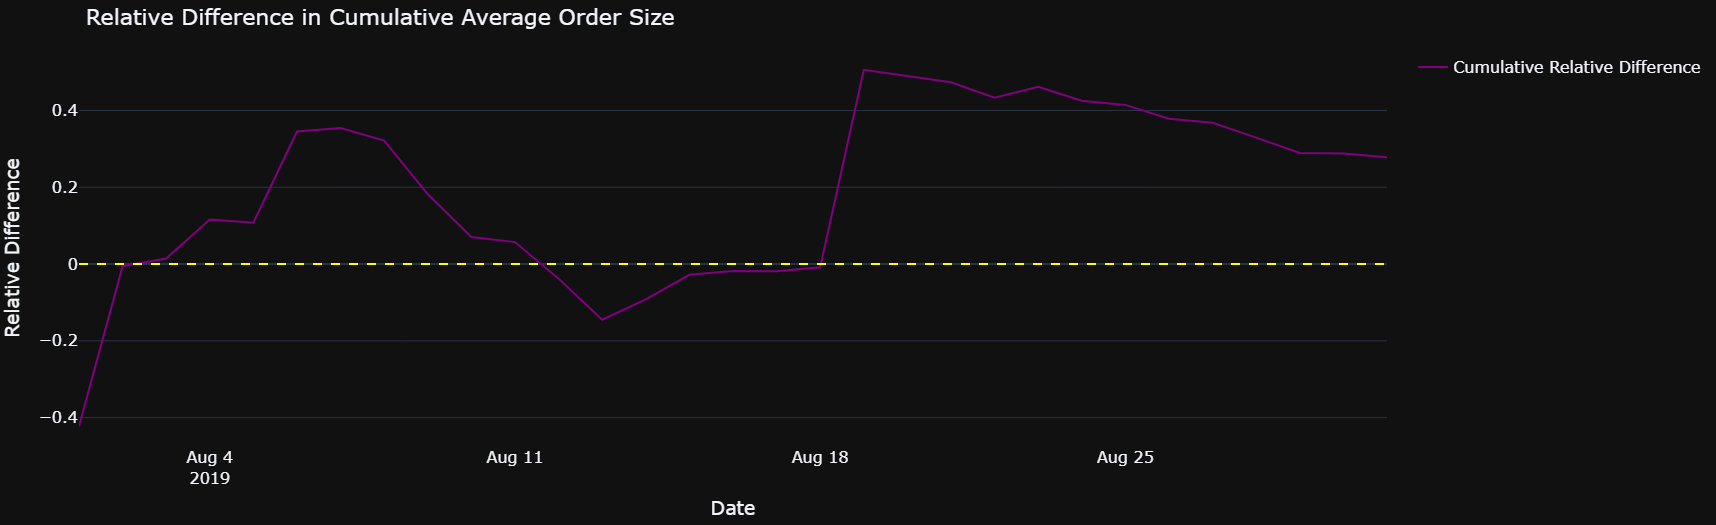

Since we are now quite certain we have an outlier in the test group, it wouldn't be very wise to make any conclusions from the above graph. 

Up until August 18th, we see what we expected to see - the relative difference between the groups is increasing significantly until August 8th (since the test group is on the rise and the control group is declining), then the trend flips until August 13th (since now the test group is steady, not rising nor falling much, but the control group is rising rapidly each day), then the relative difference shows only a mild increase due to the test group's better performance over the control group (the former increasing slightly, the latter decreasing slightly), and finally comes August 19th and its outlier which skews the result in favor of the test group. The graph is decreasing steadily from August 19th and on due to the same reason as explained previously.

The goal of this graph - assuming we had no outliers - is to show if the test group is performing better (above the zero line), worse (below the zero line), or the same as the control group (on or close to the zero line) during the test. Ideally, we would want to see the graph stabilizing either above or below the zero line, thus conclude that the test group performs better/worse than the control group (respectively) and make conclusions/decisions accordingly. 

However, up until August 18th, the results are inconclusive. The test group outperfroms the control group at first, then the control group catches up, and both groups show roughly similar results, seeing the relative difference is more or less stable around the zero line, but we can't make any conclusions yet since the graph is not stablizied anywhere. The graph from that point on is irrelevant due to the suspected outlier. 

## Graphic Representation of Each Group's Daily Conversion Rate 
This is quite straightforward. We have data for the amount of visits from each group in each day in the `visits` table. The conversion is simply the amount of buyers (unique `visitorId`'s who made at least one purchase on a given day) divided by the amount of visits. 

Unfortunately, we can't know how many *unique* users visited each day from each group, as the data in the `visits` table is only a summary, an aggregated table. This means that, in theory, 100 visits could be from 100 different people, each one contributing one visit, or from any lesser amount of users, some of which visiting the website more than once (but are counted as if they were different people). This might result in a slightly inaccurate conclusion in the analysis below, but since we have no other choice, it will have to make do. We must also remember that a certain customer could make purchases on different days - and they would contribute to the conversion on all those days. In other words, each day stands on its own. A converted user from a given day will not contribute to the conversion of the following day, if they hadn't any made purchase on that day.

Using the `orders_control` and `orders_test` tables, we can create new aggregated tables containing data on the **amount of unique users who made a purchase each day.** Then, merging these new tables with the corresponding `control_visits` and `test_visits` tables we made earlier, we will have the means to calculate the conversion for each day. Once we have that, we can plot them together as we did before.

In [26]:
# making the relevant table for the control group:
control_conversion = orders_control.groupby(orders_control['date']).agg(
buyers = ('visitorId', 'nunique')).reset_index()

# alternative way, using pivot table:
# control_conversion = orders_control.pivot_table(index = 'date', values = 'visitorId', aggfunc = 'nunique').reset_index()
# control_conversion.columns = ['date', 'buyers']

control_conversion = control_conversion.merge(control_visits, how = 'inner', on = 'date')
control_conversion['daily_conversion_%'] = (100 * (control_conversion['buyers'] / control_conversion['visits'])).round(decimals = 2)

# doing the same for the test group:
test_conversion = orders_test.groupby(orders_test['date']).agg(
buyers = ('visitorId', 'nunique')).reset_index()

test_conversion = test_conversion.merge(test_visits, how = 'inner', on = 'date')
test_conversion['daily_conversion_%'] = (100 * (test_conversion['buyers'] / test_conversion['visits'])).round(decimals = 2)

In [27]:
# checking the result for one of the tables:
test_conversion.head()

,date,buyers,group,visits,daily_conversion_%
0,2019-08-01,17,B,713,2.38
1,2019-08-02,22,B,581,3.79
2,2019-08-03,14,B,509,2.75
3,2019-08-04,13,B,770,1.69
4,2019-08-05,21,B,707,2.97


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=control_conversion['date'], 
                         y=control_conversion['daily_conversion_%'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_conversion['date'], 
                         y=test_conversion['daily_conversion_%'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Daily Conversion Comparison',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Conversion', ticksuffix = '%')

fig.show()

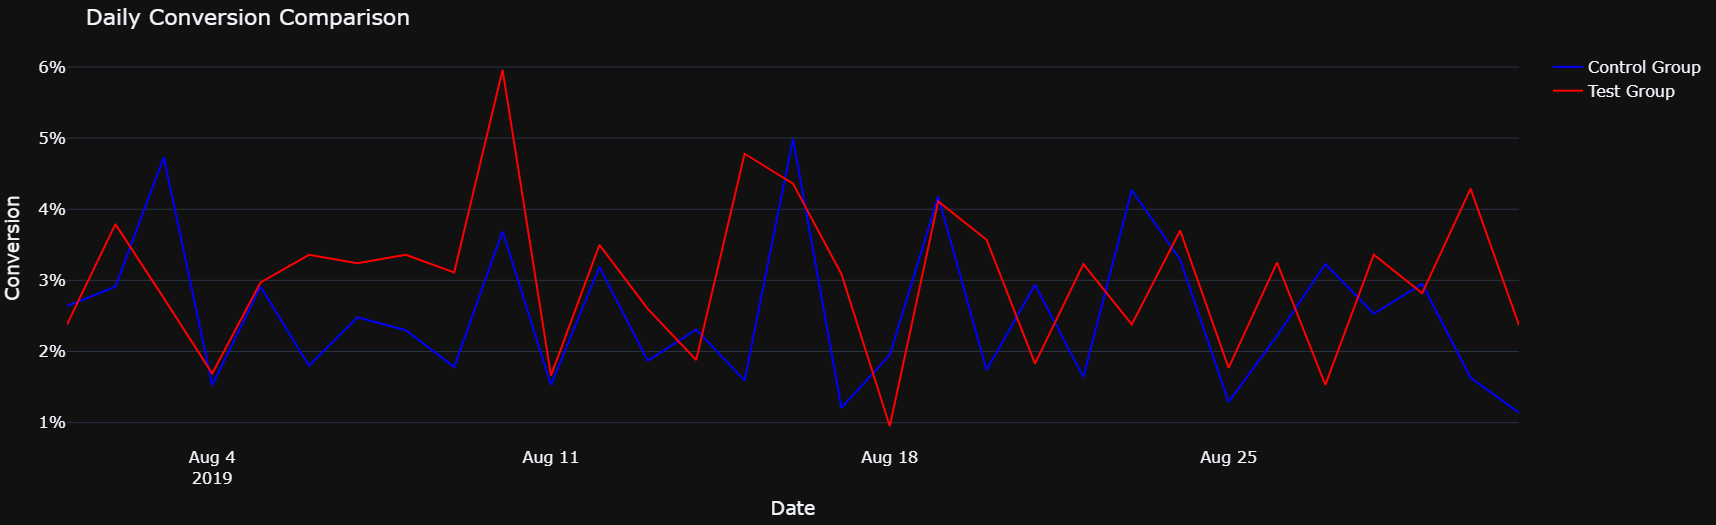

The above graph isn't very informative. We see that both groups' conversion fluctuates strongly during the test, and we can't see clearly which group perfroms better.

Therefore, it would be wiser to plot the **cumulative conversion** of both groups. For that, we will need to add more columns to the tables above - `cumulative_buyers` and `cumulative_visits`. Then we will be able to calculate the `cumulative_conversion`.

In [29]:
# updating the relevant table for the control group:
control_conversion['cumulative_buyers'] = control_conversion['buyers'].cumsum()
control_conversion['cumulative_visits'] = control_conversion['visits'].cumsum()
control_conversion['cumulative_conversion_%'] = (100 * (control_conversion['cumulative_buyers'] / control_conversion['cumulative_visits'])).round(decimals = 2)

# updating the relevant table for the test group:
test_conversion['cumulative_buyers'] = test_conversion['buyers'].cumsum()
test_conversion['cumulative_visits'] = test_conversion['visits'].cumsum()
test_conversion['cumulative_conversion_%'] = (100 * (test_conversion['cumulative_buyers'] / test_conversion['cumulative_visits'])).round(decimals = 2)

test_conversion.head()

,date,buyers,group,visits,daily_conversion_%,cumulative_buyers,cumulative_visits,cumulative_conversion_%
0,2019-08-01,17,B,713,2.38,17,713,2.38
1,2019-08-02,22,B,581,3.79,39,1294,3.01
2,2019-08-03,14,B,509,2.75,53,1803,2.94
3,2019-08-04,13,B,770,1.69,66,2573,2.57
4,2019-08-05,21,B,707,2.97,87,3280,2.65


The term "**cumulative conversion**" may be slightly misleading. The way we calculate it, it is not a metric which can only grow with time (hence the word 'cumulative'). It can also decrease. However, it is made of two other metrics which *are* cumulative - buyers and visits - but since these two can grow in different *proportions* (relative to each other), the so-called cumulative conversion can both increase or decrease with each passing day. Nonetheless, we will stick with the term "cumulative conversion". 

In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=control_conversion['date'], 
                         y=control_conversion['cumulative_conversion_%'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_conversion['date'], 
                         y=test_conversion['cumulative_conversion_%'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Cumulative Conversion (%) Comparison',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Cumulative Conversion', ticksuffix = '%')

fig.show()

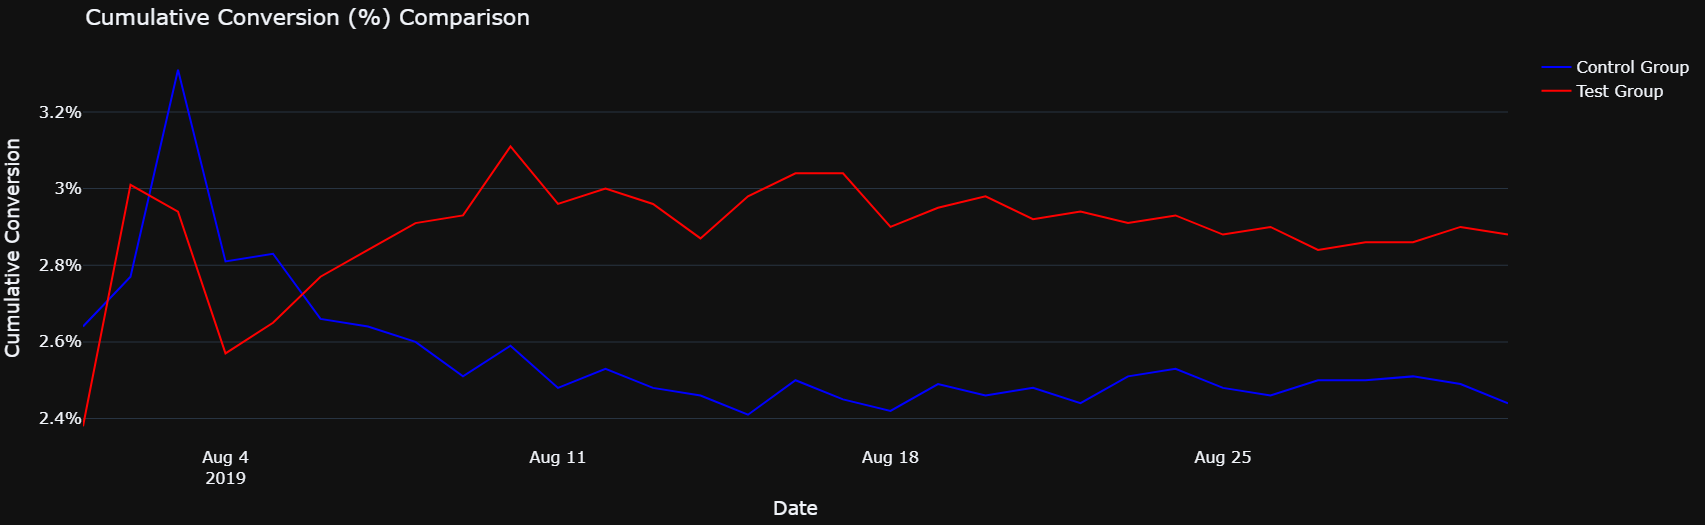

Now THIS is much more informative. We can see that in the first few days, the control group generally performed better in terms of conversion, but starting August 4th, the test group's cumulative conversion started to rise rapidly, while the control group continuted to decline. 

The control group eventually stabilized around 2.5% comulative conversion, while the test group stabilized around 2.9%. No doubt about it - the test group showed better results. It should be noted that although we suspect there is an outlier (or perhaps more) in the test group, it has less of an influence here, since we are only counting paying customers, regardless of how much they pay.

In addition to the above, here too we can plot the *relative difference* between the two groups, similarly to what we did with cumulative average order size. We already have the code from before for this purpose, we just need to alter it in the relevant places:

In [31]:
# creating the relevant table
relative_difference_conversion = pd.merge(
    control_conversion['cumulative_conversion_%'], 
    test_conversion['cumulative_conversion_%'], 
    how = "inner", 
    on = control_conversion['date'])
relative_difference_conversion.columns = ['date', 'control_group', 'test_group'] # remember - the last two columns contain the respective group's cumulative conversion %
relative_difference_conversion['relative_difference'] = (relative_difference_conversion['test_group'] / relative_difference_conversion['control_group']) - 1

relative_difference_conversion.head()

,date,control_group,test_group,relative_difference
0,2019-08-01,2.64,2.38,-0.098485
1,2019-08-02,2.77,3.01,0.086643
2,2019-08-03,3.31,2.94,-0.111782
3,2019-08-04,2.81,2.57,-0.085409
4,2019-08-05,2.83,2.65,-0.063604


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=relative_difference_conversion['date'], 
                         y=relative_difference_conversion['relative_difference'],
                         mode='lines',
                         name='Cumulative Conversion Relative Difference',line = dict(color='purple')))

fig.add_hline(y=0,line_dash="dash", line_color="yellow")

fig.update_layout(
    showlegend=True,
    title = 'Relative Difference in Cumulative Conversion',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Relative Difference')

fig.show()

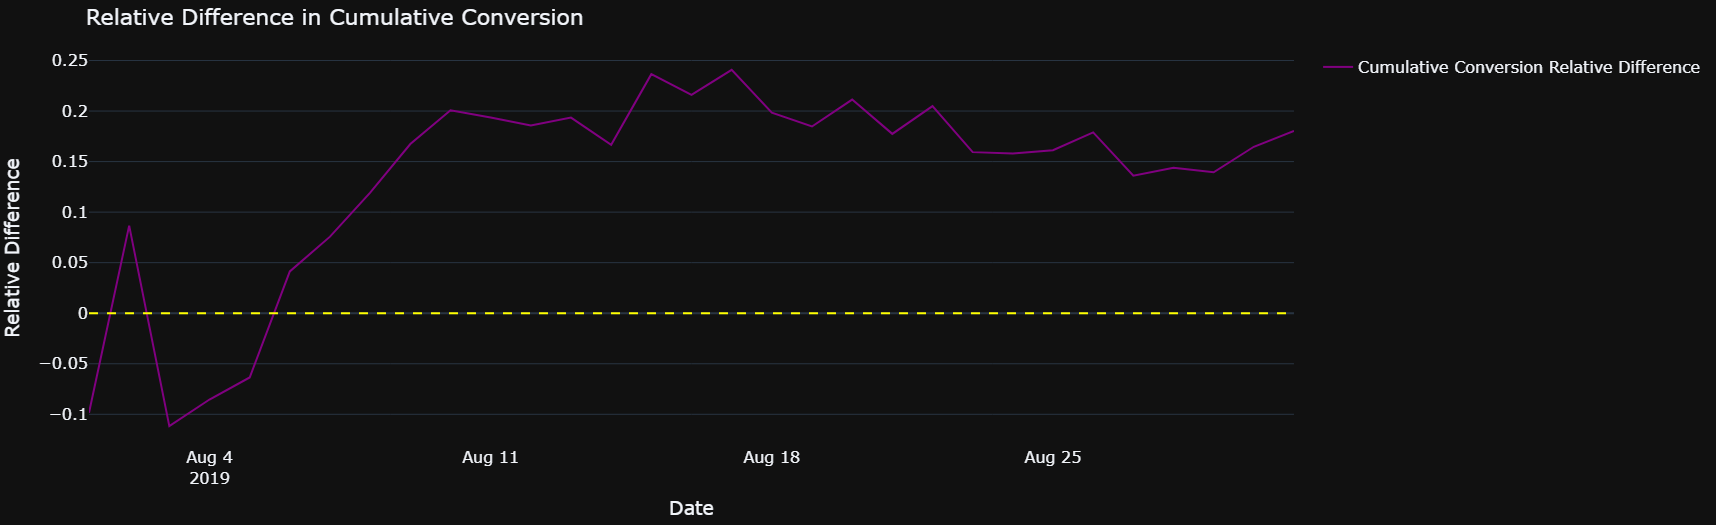

We can see it much more obviously here. Except for four days somewhere at the beginning of the test, the test group has shown better results in terms of cumulative conversion. However, we should note that although the relative difference is almost always greater than 0 (meaning the test group performed better in that regard), it doesn't seem to have fully stabilized YET, and moreover it seems to be *decreasing* in the second half of the test. Then again, this is because the cumulative conversion of the test group decresed somewhat in the second half of the test, while the control group increased a little. Be that as it may, our "bottom line" conclusion regarding each group's relative performance in terms of conversion, remains the same.

**We have to emphasize it again** - the results above are slightly inaccurate due to the fact that we have removed 58 shared buyers - belonging to both groups - from the original `orders_raw` dataframe (we did that in the Initialization stage), but could not do so in the `visits` dataframe, because the latter is an aggregated table with the sum of all visits. This means that at least some of the conversion percentages above are actually LOWER than they should really be - because the removed users still contribute to the amount of VISITS of both groups, but they do not contribute to the amount of BUYERS, thus we are actually LOWERING the conversion values in both groups. We have warned about this, but our hands are tied. That's the problem with receiving aggregated data to begin with, and not the "raw" data of the visits - which would, most likely, include information about WHO visited and WHEN. We could then remove those problematic vitiorId's from the `visits` table as well, thus not counting there visits at all, and then we wouldn't have any problem.

ALL OF THAT BEING SAID, if anyone so desires, there is a relatively simple way to see all the above graphs and tables with the more accurate numbers (meaning, **including the shared buyers, nothing removed**). In order to do so, follow these steps:

1) Go [HERE](#Graphic-Representation-of-Cumulative-Revenue-by-Group) (the link will lead you to the beginning of the analysis part).

2) In the first code cell, we define the `orders_control` (line 2) and `orders_test` (line 7) datasets. In both lines, change `orders` to `orders_raw`. Run the cell.

3) Run all subsequent cells, up to this point. This will show you all the tables and graphs, including shared users.

Just don't forget to change the `orders_control` and `orders_test` definitions BACK (and restart the kernel)! 

Having followed our own instructions in the previous markdown cell and took a look at the resulting tables and graphs, here is our main conclusion:

Although some the numbers change (naturally), especially the cumulative revenues, number of orders, conversions percentages, relative differences, etc., and although the graphs change somewhat - the *overall trends* we have seen are NOT drastically different than those we have obtained using the clean `orders` table, without the shared buyers. 

Therefore, we can definitely say that THE "BIG PICTURE" - MEANING OUR OVERALL CONCLUSIONS MADE UNTIL NOW - **REMAINS THE SAME**. 

## Scatter Chart of the Number of Orders Per User
As part of our checking for abnormal behaviour, we will want to see the typical range of amount of orders per user. For that, we can plot a scatterplot that shows just how many orders each user has made, from both groups.

For each group, we will create a table that summarizes the amount of orders each user made - regardless of date.

Once we have it, we can make the scatterplot.

In [33]:
# creating the relevant tables:
control_number_of_orders = orders_control.groupby(orders_control['visitorId']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

test_number_of_orders = orders_test.groupby(orders_test['visitorId']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

In [34]:
# checking the result for one of the tables:
test_number_of_orders.head()

,visitorId,number_of_orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Now that we have our tables, let's first check the ranges of both groups, just to get a preliminary picture:

In [35]:
# checking value counts in the control group:
control_number_of_orders['number_of_orders'].value_counts()

1    427
2     13
3      5
Name: number_of_orders, dtype: int64

In [36]:
# checking value counts in the test group:
test_number_of_orders['number_of_orders'].value_counts()

1    510
2     16
3      2
Name: number_of_orders, dtype: int64

We can already see where this is going. Even without a scatterplot (which will follow), we can see that in both groups the vast majority of users made only one order, and far less have made 2 or 3 orders, the latter being the maximum amount. We can even go as far as saying, right now, that any user who has made 2 orders or more - is considered an anomaly. However, we will soon also prove that statistically.

But before we do that, and before the scatterplot, let's see if the above conclusion would have changed had we included all of those buyers we have removed early on. This isn't part of the official analysis, it's just something we want to do out of curiousity:

In [37]:
orders_raw_control = orders_raw.query('group == "A"')
orders_raw_test = orders_raw.query('group == "B"')

control_number_of_orders_raw = orders_raw_control.groupby(orders_raw_control['visitorId']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

test_number_of_orders_raw = orders_raw_test.groupby(orders_raw_test['visitorId']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

In [38]:
# checking value counts in the control group (INCLUDING SHARED USERS):
control_number_of_orders_raw['number_of_orders'].value_counts()

1    473
2     17
3      7
4      3
5      2
7      1
Name: number_of_orders, dtype: int64

In [39]:
# checking value counts in the test group (INCLUDING SHARED USERS):
test_number_of_orders_raw['number_of_orders'].value_counts()

1    552
2     23
3      5
4      4
5      1
6      1
Name: number_of_orders, dtype: int64

Well well well. Will you look at that? First of all, had we seen this data before, we would STILL say that the vast majority of users (roughly 95%) have made only one order, and anyone who made more than that should be considered an anomaly. In addition, using the clean data, we saw that no user has made more than three orders at the maximum. Here, we see that some of our removed (shared) users have made 4, 5, and even 6 or 7 orders! These would be considered anomalies for sure (considering the value counts), and we would have removed them anyway.

Anyway, this small detour was just because we were curious. Back to the task at hand:

We will now draw the scatterplot we talked about earlier:


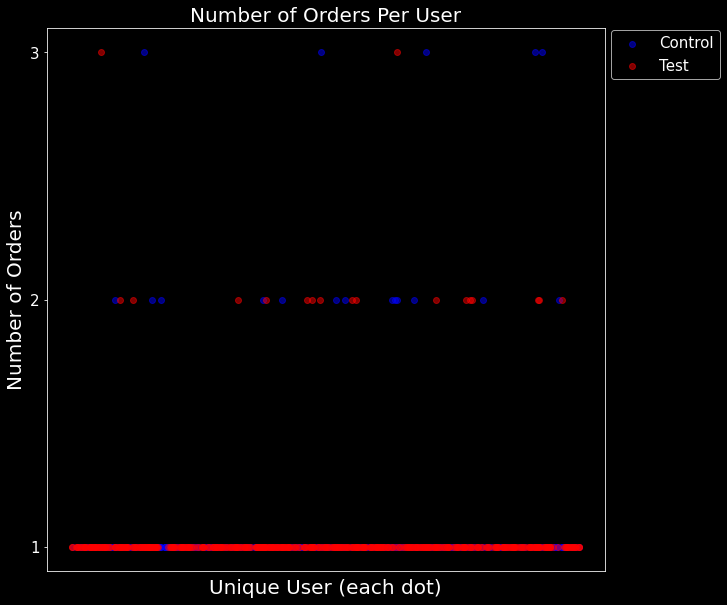

In [40]:
# plotting the graph:
plt.style.use('dark_background') # just to make the theme darker, thus easier on the eyes.

plt.figure(figsize=(10, 10))
plt.scatter(control_number_of_orders['visitorId'], control_number_of_orders['number_of_orders'], label = 'Control', color = 'blue', alpha = 0.5)
plt.scatter(test_number_of_orders['visitorId'], test_number_of_orders['number_of_orders'], label = 'Test',color = 'red', alpha = 0.5)
plt.title('Number of Orders Per User', fontsize = 20)
plt.xlabel('Unique User (each dot)', fontsize = 20)
plt.xticks([]) # the ticks of the X axis are irrelevant, so we remove them.
plt.ylabel('Number of Orders', fontsize = 20)
plt.yticks(np.arange(1, 4, 1))
plt.tick_params(axis='y', labelsize=15)
plt.legend(bbox_to_anchor=(1.22, 1.01), fontsize = 15)

plt.show()

The above scatterplot just shows what we just said. It seems that in both groups what is considered a typical behaviour is a single purchase per user. Note that the red dots "hide" the blue ones in the bottom part, but as we already know, there are 427 users in the control group that made just 1 purchase.

In order to prove it statistically, we will now calculate the 95th and 99th percentiles for the number of orders users made, in each group:

In [41]:
print ('95th and 99th percentile of number of orders (respectively), control group:', np.percentile(control_number_of_orders['number_of_orders'], [95, 99]))
print ('95th and 99th percentile of number of orders (respectively), test group:', np.percentile(test_number_of_orders['number_of_orders'], [95, 99]))

95th and 99th percentile of number of orders (respectively), control group: [1.   2.56]
95th and 99th percentile of number of orders (respectively), test group: [1. 2.]


An alternative (and perhaps more correct) way to define outliers would be to check the 95th and 99th percentiles for the number of orders users made REGARDLESS of group:

In [42]:
combined_number_of_orders = pd.concat([control_number_of_orders, test_number_of_orders])

print ('95th and 99th percentile of number of orders (respectively), all users:', np.percentile(combined_number_of_orders['number_of_orders'], [95, 99]))

95th and 99th percentile of number of orders (respectively), all users: [1. 2.]


There we have it.

Whether looking at both groups separately or together, we can see that at least 95% of the users made just 1 purchase. We can easily calculate the exact percentage of users who made more than one purchase (in each group or in total), but this is unnecessary, as the picture is quite clear.

Bottom line: 

Any user who made 2 or 3 purchases - is considered an anomaly.

## Scatter Chart of the Order Sizes
What we will do here is just like we did with number of orders. We don't even need to create new tables - we can just use `orders_control` and `test_control`, since we don't care about the dates or the users this time. Then, we will calculate the 95th and 99th percentiles for each group, and will be able to define anomalies in the data.

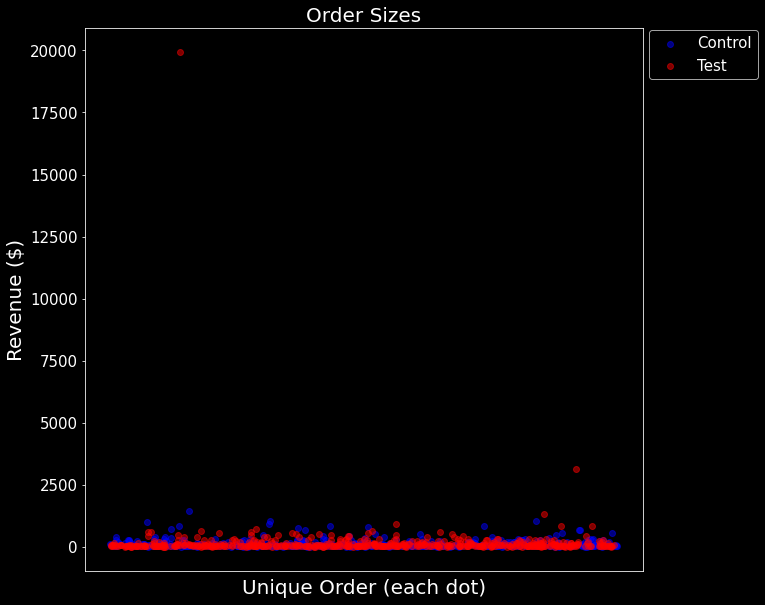

In [43]:
plt.figure(figsize=(10, 10))
plt.scatter(orders_control['transactionId'], orders_control['revenue'], label = 'Control', color = 'blue', alpha = 0.5)
plt.scatter(orders_test['transactionId'], orders_test['revenue'], label = 'Test', color = 'red', alpha = 0.5)
plt.title('Order Sizes', fontsize = 20)
plt.xlabel('Unique Order (each dot)', fontsize = 20)
plt.xticks([]) # the ticks of the X axis are irrelevant, so we remove them.
plt.ylabel('Revenue ($)', fontsize = 20)
plt.tick_params(axis='y', labelsize=15)
plt.legend(bbox_to_anchor=(1.22, 1.01), fontsize = 15)

plt.show()

The most interesting observation in the above chart is one single dot from the test group, which represents an order which totalled roughly 20,000 USD! 
This explains the "bump" in our cumulative revenue and cumulative average order size graphs earlier, a bump which occured in a very specifc date - August 19th. We suspected it was due to an outlier, and now we got our proof. 

There is another outlier coming from the test group - an order which totalled more than 2500 USD, and we can clearly see that all other orders are well under 2000 USD. 

First, let's look at the same scatterplot, but limit our Y-axis values to 1500 (we checked that, and the next-highest order from either group was less than 1500 USD):

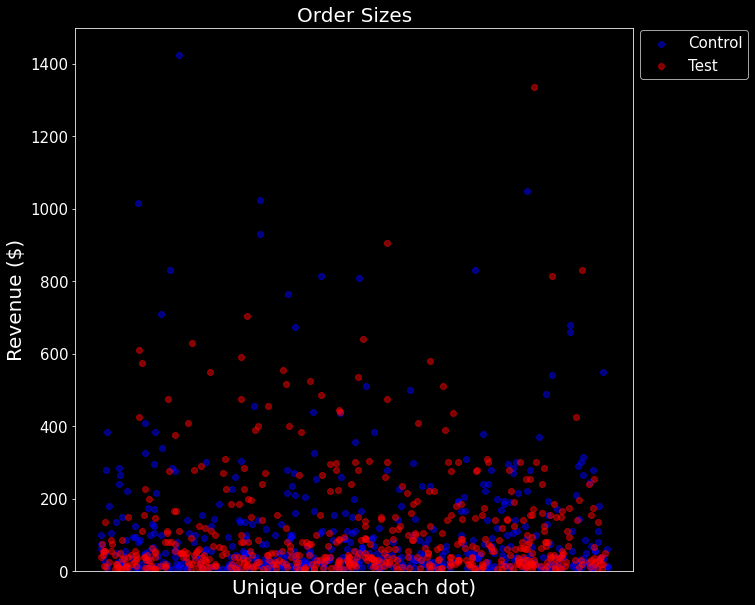

In [44]:
plt.figure(figsize=(10, 10))
plt.scatter(orders_control['transactionId'], orders_control['revenue'], label = 'Control', color = 'blue', alpha = 0.5)
plt.scatter(orders_test['transactionId'], orders_test['revenue'], label = 'Test', color = 'red', alpha = 0.5)
plt.title('Order Sizes', fontsize = 20)
plt.xlabel('Unique Order (each dot)', fontsize = 20)
plt.xticks([]) # the ticks of the X axis are irrelevant, so we remove them.
plt.ylabel('Revenue ($)', fontsize = 20)
plt.ylim(0, 1500)
plt.tick_params(axis='y', labelsize=15)
plt.legend(bbox_to_anchor=(1.22, 1.01), fontsize = 15)

plt.show()

This is a much more "normal" scatterplot. We can see that most orders are below 400 USD, but we have a fair few above that amount. In order the price above which an order is considered an anomaly, we will need to calculate, again, the 95th and 99th percentile values:

In [45]:
print ('95th and 99th percentile of order size (respectively), control group:', np.percentile(orders_control['revenue'], [95, 99]))
print ('95th and 99th percentile of order size (respectively), test group:', np.percentile(orders_test['revenue'], [95, 99]))

95th and 99th percentile of order size (respectively), control group: [385.63  863.201]
95th and 99th percentile of order size (respectively), test group: [425.795 763.865]


We can start seeing the difference between the two groups here. For the control group, at least 95% of orders were below 386 USD, while for the test group the equivalent figure was 426 USD. The 99th percentiles are even more farther apart, with the control group having a higher 99th percentile order total than the test group's.

Let's assume that we consider any order totalling more than the 95th percentile value as an anomaly - how would we consider a given order totalling 400 USD? The answer is "it depends" - if that order was made by a member of the test group - we would say "OK, that's normal". However, if that EXACT same order had been made by a member of the control group - we would say "No no no, this is an anomaly! drop it!". So, it is possible that we have two different people - Mr. A and Mr. B - who are very good friends, and who have both made the EXACT same order which cost them 400 USD, but one of them belongs to the control group, and the other one to the test group. In that case, when we remove anomalies from our data, Mr. B from the test group will survive the anomaly purge, but Mr. A will not. Seems a bit unfair, as both of them made the exact same purchase, but Mr. A is considered an anomaly just because the *other* members of the control group didn't make more expensive orders, statistically.

This leaves us with only one choice: We will have to check what are the 95th and 99th percentile prices for the ENTIRE `orders` list, REGARDLESS OF GROUP.
The figures will get will define what is considered a normal behaviour, and what is considered an anomaly.

In [46]:
print ('95th and 99th percentile of order size (respectively), all users:', np.percentile(orders['revenue'], [95, 99]))

95th and 99th percentile of order size (respectively), all users: [414.275 830.3  ]


Well, there it is. at least 95% of all orders, regardless of group, totalled 414.275 USD or less. Therefore, if and when we filter our orders data, we will have to remove all orders above that number, no matter from which group that order came from, and even more importantly - no matter if that order is considered normal when we look only at the orders of the same group that order came from.

## Finding the Statistical Significance of the Difference in Conversion Between the Groups Using the RAW Data

The time has come for the main event! It's time to see what exactly are the differences between the control and the test groups, after 1 month of testing.

We will start by checking the differences using the **RAW data**. Reminder - it is raw except for the fact we removed some users from the `orders` table. All outliers, including the abnormally high orders and the users who made 2 or 3 purchases - are still in play!

The first thing we are going to check is the statistical significance of the difference in CONVERSION between the groups.

There are in fact TWO WAYS in which we can do that:

1) We can compare the *total* conversion in both groups, in terms of simple *proportion*. For that, we can use what is known as **Z-TEST**. In it, we simply compare the proportions of the two groups, and produce a p-value. We basically test a hypothesis that the two proportions are the same (this is the *null* hypothesis), which is why we need to define an alpha value as well. If our calculated p-value is lower than alpha - the null hypothesis is *rejected*, and we conclude that the two proportions are NOT the same, and their difference is statistically significant.

In order to do this, we will use a library function called `proportions_ztest`, imported from `statmodels.stats.proportion`.

2) This will be a more exact test. For each one of the groups, we will create a list of that group's visits, where each visit ending with a purchase (conversion of a user) will be given a value equal to the amount of purchases, and the other visits (no purchase made) will be given the value of "0". In other words, each element in the lists is the number of orders made by a certain user, including zeroes. We will use these lists - or, more precisely, SAMPLES - to calculate/test the difference in conversion between the two groups.

As for which test to use - this will be decided by whether the values of both groups are normally distributed or not. If BOTH samples are normally distributed - we will use the t-test, and also check for equiality/inequiality of their variances). If at least on of the samples is NOT normally distributed, we will use the Mann-Whitney test.

Checking the distributions of the groups will be done by applying the Shapiro Test, which tests the "hypothesis" that the distribution is normal. If the calculated p-value is less than alpha - this hypothesis is rejected, and it means the distribution is NOT normal.

In order to do all this, we will write a function that:

a) Checks the normality of the distributions of both samples (the Shapiro Test).

b) If both are normal, it checks for equality of their variances (Levene's Test), and performs the appropriate t-test.

c) If at least on of the sample's distribution is NOT normal, then the Mann-Whitney test is carried out.

d) Prints which test has been performed, the calculated p-value, and states whether the null hypothesis is rejected or not.

NOTE: for all intents and purposes, **we define alpha to be equal to 0.05**.

In [47]:
# starting with number 1 above, making preparations for the Z-test.
# calculating the total conversions in both groups, using RAW data:

# control group:
control_total_buyers = control_conversion['buyers'].sum()
control_total_visits = control_conversion['visits'].sum()
control_total_conversion = control_total_buyers / control_total_visits

# test group:
test_total_buyers = test_conversion['buyers'].sum()
test_total_visits = test_conversion['visits'].sum()
test_total_conversion = test_total_buyers / test_total_visits

# printing the results:
print ('Control group: total buyers', control_total_buyers, ', total visits', control_total_visits, ', total conversion {:.2%}'.format(control_total_conversion))
print ('Test group: total buyers', test_total_buyers, ', total visits', test_total_visits, ', total conversion {:.2%}'.format(test_total_conversion))

Control group: total buyers 457 , total visits 18736 , total conversion 2.44%
Test group: total buyers 544 , total visits 18916 , total conversion 2.88%


Seeing a 0.44% difference is well and nice. But does it count as "an equal proportion"? We'll now run the Z-test:

In [48]:
def check_zvalue (buyers1 , visits1, buyers2, visits2):
    
    alpha = 0.05 # we define the alpha value as the industry standard.
    stat, p_value = proportions_ztest([buyers1, buyers2], [visits1 ,visits2])
    
    print('p-value: {:.5f}'.format(p_value))
    if p_value < alpha:
        print ('Null hypothesis rejected - the proportions are significantly different')
    else:
        print ('Failed to reject null hypothesis - there is no reason to consider the proportions different')

In [49]:
# performing the Z-test by running our function above:
check_zvalue (control_total_buyers, control_total_visits, test_total_buyers, test_total_visits)

p-value: 0.00844
Null hypothesis rejected - the proportions are significantly different


We see that the p-value generated by our Z-test is 0.00844, which is quite less than our alpha (0.05). This means that our null hypothesis that the two samples are the same - is REJECTED: The proportions are SIGNIFICANTLY DIFFERENT.

In other words - though a 0.44% may not seem like a lot, according to the Z-test it actually is, seeing as the test led to the conclusion that the proportions are significantly different.

Now we will write the function we described for executing option 2 described above:

In [50]:
def test_hypothesis (sample1, sample2, alpha=0.05):
    # begin by performing the Shapiro test - check whether distributions are normal or not:
    sample1 = sample1.dropna() # drop null values, in case there are any.
    sample2 = sample2.dropna()
    stat1, p1_norm = stats.shapiro(sample1)
    stat2, p2_norm = stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        # both distributions normal, perform t-test.
        # begin by checking variances:
        statslev, p_levene = stats.levene(sample1, sample2)
        if p_levene < alpha:
           # variances are not equal. set t-test accordingly:
            print ('t-test, non-equal variance:')
            statist, p_value = stats.ttest_ind(sample1, sample2, equal_var = False)
        else:
            # varianes are equal. set t-test accordingly:
            print ('t-test, equal variance:')
            statist, p_value = stats.ttest_ind(sample1, sample2, equal_var = True) 
    else:
        print ('Mann-Whitney test:')
        statist, p_value = stats.mannwhitneyu(sample1, sample2)
    print('p_value: {:.5f}'.format(p_value))
    if p_value < alpha:
        print('Null hypothesis rejected - the groups have a statistically significant difference')
    else:
        print('Failed to reject null hypothesis - the groups MAY NOT have a statistically significant difference')

Next, we need to prepare our samples. This is what we will do now.

In [51]:
# first, we make a list of all users who made a purchase (and how many purchases they made, although we do not need this information).
# we will use the `orders` dataframe we made early on, as it does not contain shared users between the two groups.
control_buyers_list = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
control_buyers_list.columns = ['visitorId', 'orders']

# now, we do the same for the test group.
test_buyers_list = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
test_buyers_list.columns = ['visitorId', 'orders']

# now, we will make the samples themselves. these are, as explained, lists where each element is the number of orders made by a certain user, including zeroes.

sample_control = pd.concat([control_buyers_list['orders'], 
                            pd.Series(0, index=np.arange(control_visits['visits'].sum() - len(control_buyers_list)), name='orders')],axis=0)

sample_test = pd.concat([test_buyers_list['orders'], 
                            pd.Series(0, index=np.arange(test_visits['visits'].sum() - len(test_buyers_list)), name='orders')],axis=0)

reminder: 

`control_visits['visits'].sum()` = amount of all visits. 
           
`len(control_buyers_list)` = amount of (unique) buyers.

the sample is a concatenated list of the unique buyers's amount of purchases, and a series of 0's (visits with no purchases), the length of which equals the amount of all visits minues the amount of unique buyers.

In [52]:
# sanity check: the length of each sample should equal to the total amount of visits of each group:
print (len(sample_control) == control_visits['visits'].sum())
print (len(sample_test) == test_visits['visits'].sum())

True
True


Now that we have our samples, we can do the test:

Remember, the null hypothesis we're testing is that the conversion rates of the two groups are equal.

The alternative hypothesis is that they are NOT equal.

In [53]:
print ('Average conversion of the control group: {:.2%}'.format(sample_control.mean()))
print ('Average conversion of the test group: {:.2%}'.format(sample_test.mean()))
print ('Relative gain: {:.2%}'.format((sample_test.mean() / sample_control.mean()) - 1))
test_hypothesis(sample_control, sample_test)

Average conversion of the control group: 2.50%
Average conversion of the test group: 2.90%
Relative gain: 15.98%
Mann-Whitney test:
p_value: 0.01102
Null hypothesis rejected - the groups have a statistically significant difference


C:\Users\pc\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



We can see here that the conversion rates of the two groups are very close to those we calculated earlier (during the Z-test). Those were 2.44% and 2.88%, respectively. And here too, the null hypothesis is rejected, meaning there is a statistically significant difference between the two groups in terms of conversion. We must note that the *relative difference* between the groups is 16% - which is a substantial increase in conversion. Thus, according to the raw data, the test group performed better in that regard - but we must remember we are using the raw data here. Outliers are still in play, so we must be careful not to conclude anything yet.

## Finding the Statistical Significance of the Difference in Average Order Size Between the Groups Using the RAW Data

This is just like we did a moment ago, but now we will compare the revenues received by both groups, and test the hypothesis that they are the same. We will use the `test_hypothesis` function from above.

The null hypothesis is that the average order sizes of the two groups are the same.

The alternative hypothesis is that they are NOT the same.

In [54]:
print ('Average order size, control group:', orders_control['revenue'].mean())
print ('Average order size, test group:', orders_test['revenue'].mean())
print ('Relative gain: {:.2%}'.format((orders_test['revenue'].mean() / orders_control['revenue'].mean()) - 1))
test_hypothesis(orders_control['revenue'], orders_test['revenue'])

Average order size, control group: 113.70085470085463
Average order size, test group: 145.34890510948907
Relative gain: 27.83%
Mann-Whitney test:
p_value: 0.86223
Failed to reject null hypothesis - the groups MAY NOT have a statistically significant difference


This is a little unexpected: we got a VERY high p-value, much higher than our alpha, and thus failed to reject our null hypothesis. As much as it sounds weird, this means that the two groups may NOT have a statistically significant difference between them, according to the statistical test. Meaning, according to the test result - the average order sizes for the two groups might be the same, and the differences we see were obtained randomly! That's quite absurd, as we can clearly see that there is quite a difference between the groups - The test group's average order size is 27.83% larger than the control group's.

The most appropriate question now is...what gives? 

We don't know. What we do know and remember is that we have outliers here, and some really big ones. So, with all due respect to this unexpected result, it's time to filter out our data, and re-run the tests. 

# Filtering the Data, Redrawing Graphs.

Time to do exactly what we did before, but this time use a FILTERED data.

Previously, we checked what is the typical amount of orders a given user makes. We have found that, in both groups, at least 95% of the users make only 1 purchase, with the remaining users making 2-3 orders. We decided that any user more than 1 purchase is considered an anomaly, thus must be removed.

In addition, we checked for anomalous order sizes. We have reached a decision that any order above 414.275 USD is an anomaly, thus must be removed. This means we should ALSO remove the USERs who made such high purchases, as these cannot be considered normal.

Therefore, this is what we'll do, for each group separately:

1) Using the corresponding `number_of_orders` table, we will make a list of all the `visitorId`'s who have more than 1 order, or, more precisely, more orders than the 95th percentile of the general `combined_number_of_orders['number_of_orders']` list.

2) Using the corresponding `orders` table (e.g. `orders_control`), we will make a list of all the `visitorId`'s who made an order more expensive than 414.275 USD, or more precisely, more expensive than the 95th percentile of the general `orders['revenue']` list.

We will combine the above lists of anomalous `visitorId`'s of each group, and remove them from our data wherever applicable, while creating new, filtered tables. This will make sure that nowhere in our data will we have a single user who has either made more than 1 order AND/OR made a too-expensive order.

We will use the now-filtered data to:

1) Re-draw the graphs we have made before (with the raw data) to see how they changed. 

2) Prepare new samples

3) Repeat all tests.

Once we'll see the test results, we will formulate our final conclusions.

In [55]:
# creating a series of visitorId's with more than 1 orders in the control group:
control_anomalous_users_1 = control_number_of_orders[control_number_of_orders['number_of_orders'] > 
                                                   np.percentile(combined_number_of_orders['number_of_orders'], 95)]['visitorId']
# creating a series of visitorId's who made too expensive orders:
control_anomalous_users_2 = orders_control[orders_control['revenue'] >
                                          np.percentile(orders['revenue'], 95)]['visitorId']
# combining the series, removing duplicates (if there are any):
control_anomalous_users = pd.concat([control_anomalous_users_1, control_anomalous_users_2])
control_anomalous_users = control_anomalous_users.drop_duplicates()

# doing the same for the test group:
test_anomalous_users_1 = test_number_of_orders[test_number_of_orders['number_of_orders'] > 
                                                   np.percentile(combined_number_of_orders['number_of_orders'], 95)]['visitorId']

test_anomalous_users_2 = orders_test[orders_test['revenue'] >
                                          np.percentile(orders['revenue'], 95)]['visitorId']

test_anomalous_users = pd.concat([test_anomalous_users_1, test_anomalous_users_2])
test_anomalous_users = test_anomalous_users.drop_duplicates()

# making a combined series for both groups:
all_anomalous_users = pd.concat([control_anomalous_users, test_anomalous_users])

# turning all series into lists:
control_anomalous_users = control_anomalous_users.to_list()
test_anomalous_users = test_anomalous_users.to_list()
all_anomalous_users = all_anomalous_users.to_list()

In [56]:
# checking the results:
print ('Amount of anomalous users in the control group:', len(control_anomalous_users))
print ('Amount of anomalous users in the test group:', len(test_anomalous_users))
print ('total amount of anomalous users:', len(all_anomalous_users))

Amount of anomalous users in the control group: 39
Amount of anomalous users in the test group: 47
total amount of anomalous users: 86


Bottom line: 86 users from both groups are going to be removed.

Next step: we are going to re-create some of our tables from before, but without the anomalous users (and orders), and use them to re-draw some of our graphs. It will be interesting to see how these would look now, with all outliers removed. 

We are basically going to repeat the same code from before, but apply filters to removed said users.

## Graphic Representation of Cumulative Revenue by Group - Filtered Data

In [57]:
# creating a new `orders` dataframe, filtered from all anomalous users:
orders_filtered = orders[~orders['visitorId'].isin(all_anomalous_users)]

# creating a slice of the control group's cumulative orders by date:
orders_control_filtered = orders_filtered.query('group == "A"')
control_data_filtered = orders_control_filtered.groupby(orders_control_filtered['date'])['revenue'].sum().reset_index()
control_data_filtered['cumulative_revenue'] = control_data_filtered['revenue'].cumsum()

# doing the same for the test group's orders:
orders_test_filtered = orders_filtered.query('group == "B"')
test_data_filtered = orders_test_filtered.groupby(orders_test_filtered['date'])['revenue'].sum().reset_index()
test_data_filtered['cumulative_revenue'] = test_data_filtered['revenue'].cumsum()

In [58]:
# checking the result for one of the tables:
test_data_filtered.head()

,date,revenue,cumulative_revenue
0,2019-08-01,967.2,967.2
1,2019-08-02,1366.7,2333.9
2,2019-08-03,1071.6,3405.5
3,2019-08-04,845.6,4251.1
4,2019-08-05,1009.1,5260.2


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=control_data_filtered['date'], 
                         y=control_data_filtered['cumulative_revenue'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_data_filtered['date'], 
                         y=test_data_filtered['cumulative_revenue'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Cumulative Revenue Comparison, Filtered Data',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Cumulative Revenue', tickprefix = '$')

fig.show()

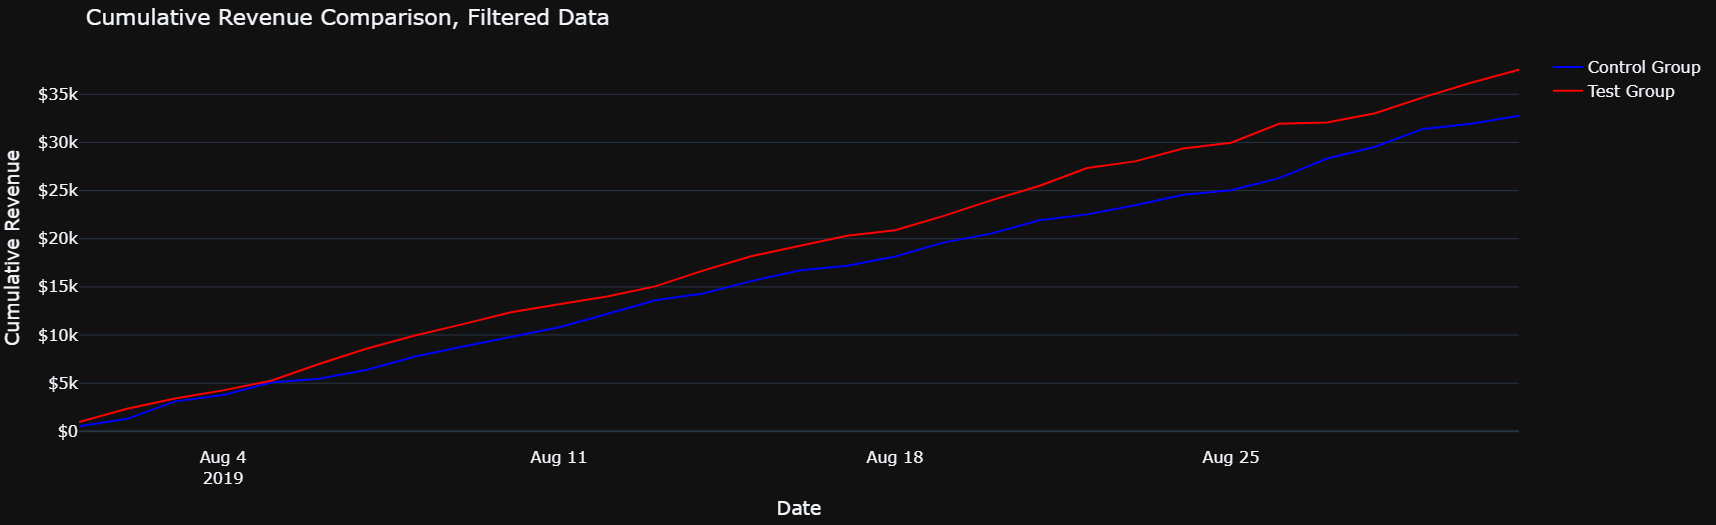

This looks much different than the original Cumulative Revenue Comparison graph. No "bumps" due to outliers. And, we can clearly see that as the test went on, the test group's cumulative revenue increased more, compared to the control group. Here and there the control groups shrinks the gap slightly, but overall we see the test group has the advantage. 

## Graphic Representation of Cumulative Average Order Size by Group - Filtered Data

In [60]:
control_number_of_orders_filtered = orders_control_filtered.groupby(orders_control_filtered['date']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

test_number_of_orders_filtered = orders_test_filtered.groupby(orders_test_filtered['date']).agg(
    number_of_orders = ('revenue', 'count')
).reset_index()

# adding the `number_of_orders` column from the above tables to the corresponding data tables from before:
control_data_filtered['number_of_orders'] = control_number_of_orders_filtered['number_of_orders']
test_data_filtered['number_of_orders'] = test_number_of_orders_filtered['number_of_orders']

# adding the additional columns described above:
control_data_filtered['cumulative_number_of_orders'] = control_data_filtered['number_of_orders'].cumsum()
control_data_filtered['cumulative_average_order_size'] = (control_data_filtered['cumulative_revenue'] /
                                                          control_data_filtered['cumulative_number_of_orders']).round(decimals = 1)

test_data_filtered['cumulative_number_of_orders'] = test_data_filtered['number_of_orders'].cumsum()
test_data_filtered['cumulative_average_order_size'] = (test_data_filtered['cumulative_revenue'] /
                                                       test_data_filtered['cumulative_number_of_orders']).round(decimals = 1)

In [61]:
# checking the result for one of the tables:
test_data_filtered.head()

,date,revenue,cumulative_revenue,number_of_orders,cumulative_number_of_orders,cumulative_average_order_size
0,2019-08-01,967.2,967.2,17,17,56.9
1,2019-08-02,1366.7,2333.9,18,35,66.7
2,2019-08-03,1071.6,3405.5,14,49,69.5
3,2019-08-04,845.6,4251.1,11,60,70.9
4,2019-08-05,1009.1,5260.2,20,80,65.8


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=control_data_filtered['date'], 
                         y=control_data_filtered['cumulative_average_order_size'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_data_filtered['date'], 
                         y=test_data_filtered['cumulative_average_order_size'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Cumulative Average Order Size Comparison, Filtered Data',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Cumulative Average Order Size', tickprefix = '$')

fig.show()

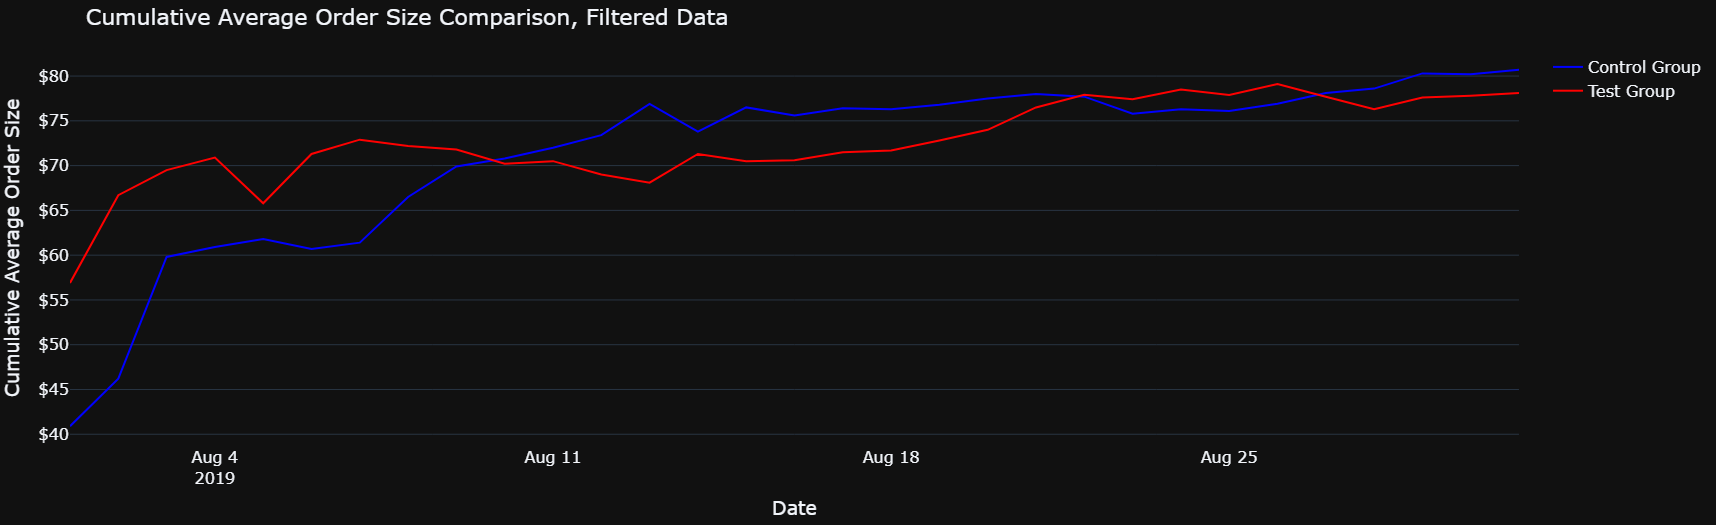

It's amazing how much the picture can change when you removed all those pesky outliers. At the onset of the test, the test group performed better in terms of cumulative average order size. However, after August 10th, the control group took the lead. Then on August 22nd, the test group was on top again, and on August 27th the control group performed better. In other words the two groups took turns in leading the race, but we can see that towards the end of the month, both groups' metrics stabilized more or less around the 80 USD mark (plus-minus 2 USD), with only a minor difference between them. No clear winner here.

## Graphic Representation of the Relative Difference in Cumulative Average Order Size - Filtered Data

In [63]:
# creating the relevant table
relative_difference_filtered = pd.merge(
    control_data_filtered['cumulative_average_order_size'], 
    test_data_filtered['cumulative_average_order_size'], 
    how = "inner", 
    on = control_data['date'])
relative_difference_filtered.columns = ['date', 'control_group', 'test_group'] # remember - the last two columns contain the respective group's cumulative average order size!
relative_difference_filtered['relative_difference'] = (relative_difference_filtered['test_group'] / relative_difference_filtered['control_group']) - 1

relative_difference_filtered.head()

,date,control_group,test_group,relative_difference
0,2019-08-01,40.9,56.9,0.391198
1,2019-08-02,46.2,66.7,0.443723
2,2019-08-03,59.8,69.5,0.162207
3,2019-08-04,60.9,70.9,0.164204
4,2019-08-05,61.8,65.8,0.064725


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=relative_difference_filtered['date'], 
                         y=relative_difference_filtered['relative_difference'],
                         mode='lines',
                         name='Cumulative Relative Difference',line = dict(color='purple')))

fig.add_hline(y=0,line_dash="dash", line_color="yellow")

fig.update_layout(
    showlegend=True,
    title = 'Relative Difference in Cumulative Average Order Size, Filtered Data',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Relative Difference')

fig.show()

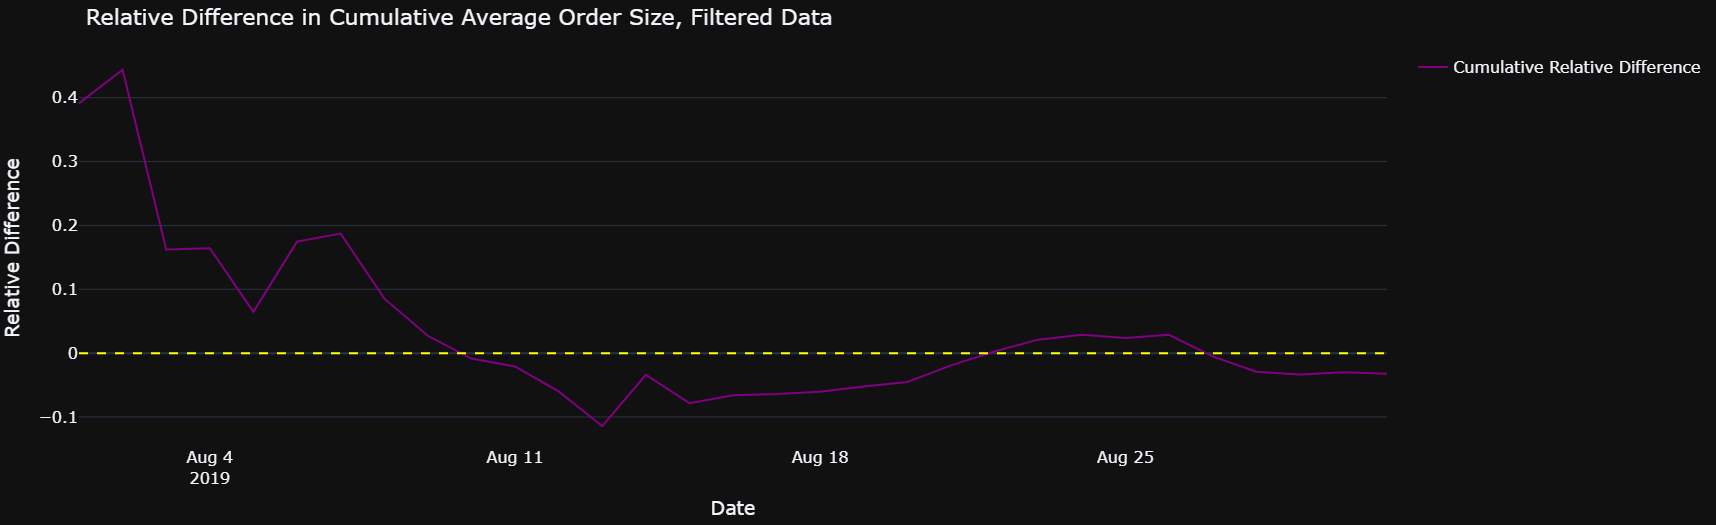

This graph shows what we just described, but in a different way. At the beginning - the test group outperformed the control groups. Then the roles switched, and then, by the end of the month, the relative difference between the two groups has stablized around the zero line, meaning there was a very small difference between them (very similar cumulative average order size). This graph does exactly what we want - stablizes somewhere, allowing us to reach a clear conclusion.

## Graphic Representation of Each Group's Daily Conversion Rate - Filtered Data

In [65]:
# making the relevant table for the control group:
control_conversion_filtered = orders_control_filtered.groupby(orders_control_filtered['date']).agg(
buyers = ('visitorId', 'nunique')).reset_index()

control_conversion_filtered = control_conversion_filtered.merge(control_visits, how = 'inner', on = 'date')
control_conversion_filtered['daily_conversion_%'] = (100 * (control_conversion_filtered['buyers'] / control_conversion_filtered['visits'])).round(decimals = 2)

# doing the same for the test group:
test_conversion_filtered = orders_test_filtered.groupby(orders_test_filtered['date']).agg(
buyers = ('visitorId', 'nunique')).reset_index()

test_conversion_filtered = test_conversion_filtered.merge(test_visits, how = 'inner', on = 'date')
test_conversion_filtered['daily_conversion_%'] = (100 * (test_conversion_filtered['buyers'] / test_conversion_filtered['visits'])).round(decimals = 2)

In [66]:
# checking the result for one of the tables:
test_conversion_filtered.head()

,date,buyers,group,visits,daily_conversion_%
0,2019-08-01,17,B,713,2.38
1,2019-08-02,18,B,581,3.10
2,2019-08-03,14,B,509,2.75
3,2019-08-04,11,B,770,1.43
4,2019-08-05,20,B,707,2.83


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=control_conversion_filtered['date'], 
                         y=control_conversion_filtered['daily_conversion_%'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_conversion_filtered['date'], 
                         y=test_conversion_filtered['daily_conversion_%'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Daily Conversion Comparison, Filtered Data',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Conversion', ticksuffix = '%')

fig.show()

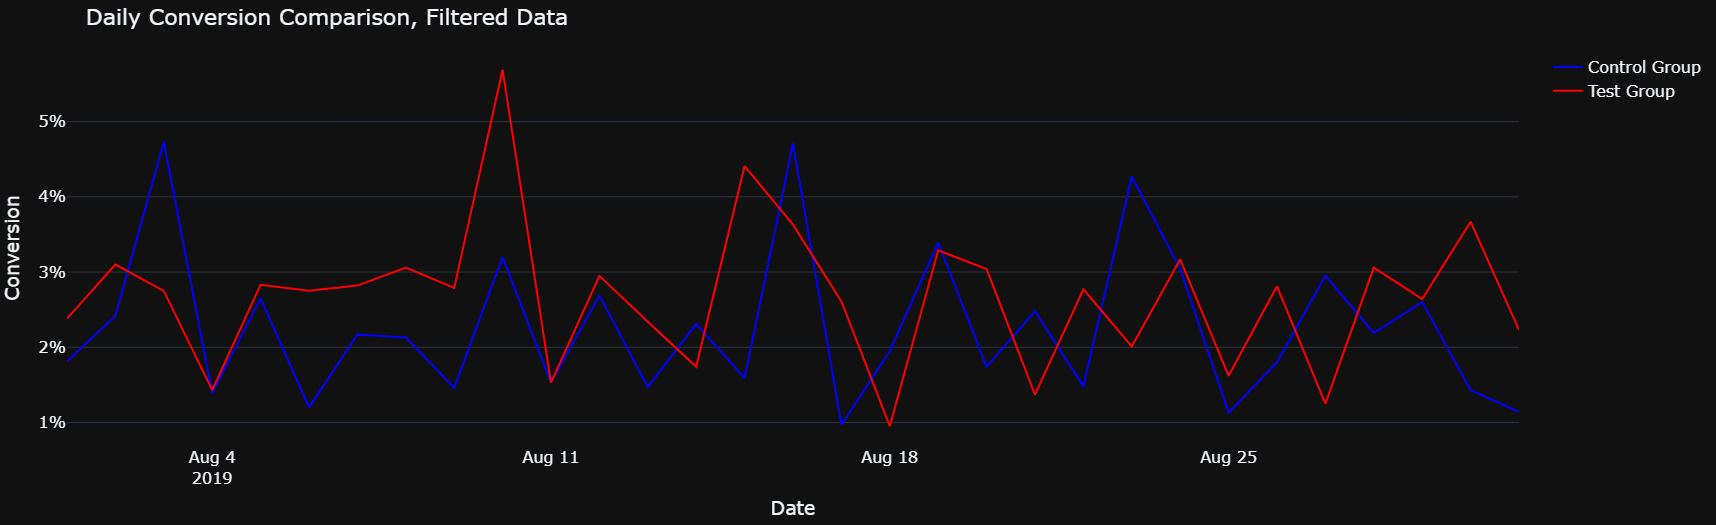

Though this graph looks different from the equivalent raw-data graph - it is still too messy and isn't very informative. We'll do just what we did before - check the cumulative daily conversion, instead.

In [68]:
# updating the relevant table for the control group:
control_conversion_filtered['cumulative_buyers'] = control_conversion_filtered['buyers'].cumsum()
control_conversion_filtered['cumulative_visits'] = control_conversion_filtered['visits'].cumsum()
control_conversion_filtered['cumulative_conversion_%'] = (100 * (control_conversion_filtered['cumulative_buyers'] / 
                                                                 control_conversion_filtered['cumulative_visits'])).round(decimals = 2)

# updating the relevant table for the test group:
test_conversion_filtered['cumulative_buyers'] = test_conversion_filtered['buyers'].cumsum()
test_conversion_filtered['cumulative_visits'] = test_conversion_filtered['visits'].cumsum()
test_conversion_filtered['cumulative_conversion_%'] = (100 * (test_conversion_filtered['cumulative_buyers'] /
                                                              test_conversion_filtered['cumulative_visits'])).round(decimals = 2)

test_conversion_filtered.head()

,date,buyers,group,visits,daily_conversion_%,cumulative_buyers,cumulative_visits,cumulative_conversion_%
0,2019-08-01,17,B,713,2.38,17,713,2.38
1,2019-08-02,18,B,581,3.10,35,1294,2.70
2,2019-08-03,14,B,509,2.75,49,1803,2.72
3,2019-08-04,11,B,770,1.43,60,2573,2.33
4,2019-08-05,20,B,707,2.83,80,3280,2.44


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=control_conversion_filtered['date'], 
                         y=control_conversion_filtered['cumulative_conversion_%'],
                         mode='lines',
                         name='Control Group',line = dict(color='blue')))

fig.add_trace(go.Scatter(x=test_conversion_filtered['date'], 
                         y=test_conversion_filtered['cumulative_conversion_%'],
                         mode='lines',
                         name='Test Group',line = dict(color='red')))

fig.update_layout(
    showlegend=True,
    title = 'Cumulative Conversion (%) Comparison, Filtered Data',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Cumulative Conversion', ticksuffix = '%')

fig.show()

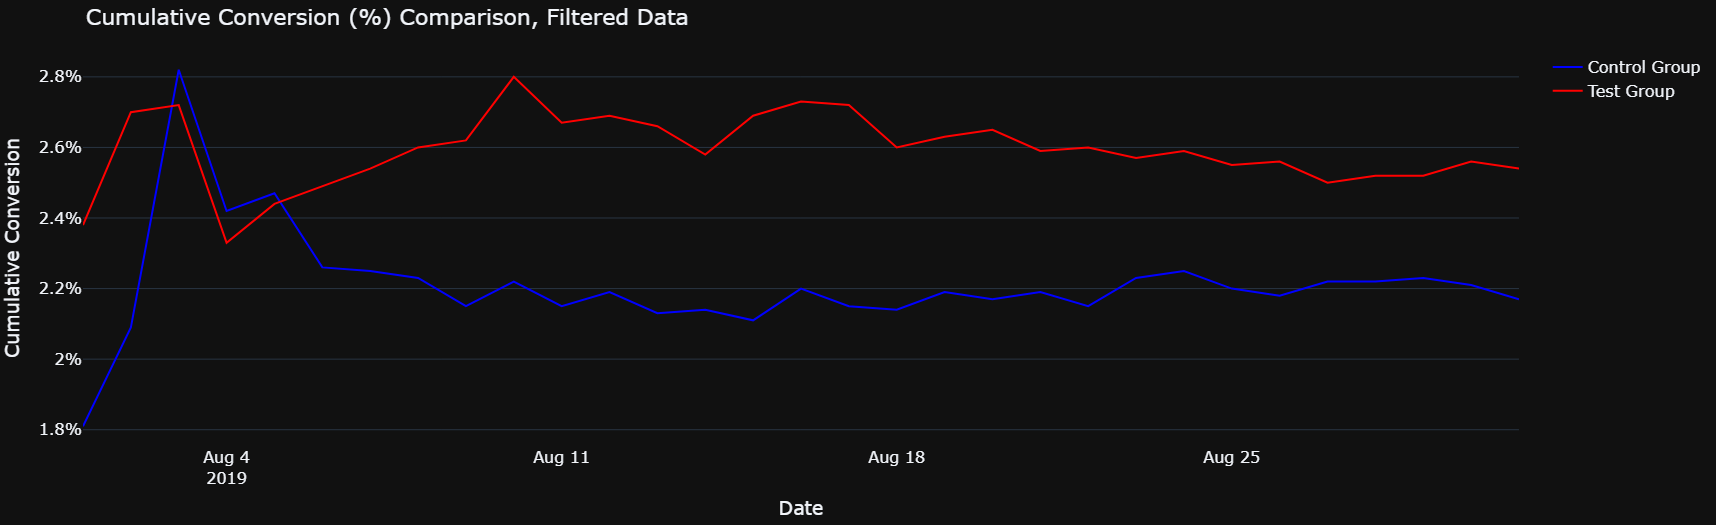

This graph isn't too different from the equivalent raw-data one, except for two things:

1) the beginning of the graphs looks slightly different, but it's not very interesting.

2) The figures around which each group stabilizes is (naturally) lower than we found previously. The test group stabilizes around 2.5% (previously 2.9%), and the control group stabilizes around 2.2% (previously 2.5%). This means our conclusion from earlier isn't changed, even though the numbers are a tad smaller. The test group is still winner in terms of cumulative conversion. This will also be tested soon.

Let us not forget that our data of `visits` is untouched, simply because it is aggregated in the first place, and now we have cut a significant chunk of users and their orders, bringing the conversion rates of each group further down, after we already did so when we cut the shared users.

Now let's look at the relative difference:

In [70]:
# creating the relevant table
relative_difference_conversion_filtered = pd.merge(
    control_conversion_filtered['cumulative_conversion_%'], 
    test_conversion_filtered['cumulative_conversion_%'], 
    how = "inner", 
    on = control_conversion_filtered['date'])

relative_difference_conversion_filtered.columns = ['date', 'control_group', 'test_group'] # remember - the last two columns contain the respective group's cumulative conversion %
relative_difference_conversion_filtered['relative_difference'] = (relative_difference_conversion_filtered['test_group'] / 
                                                                  relative_difference_conversion_filtered['control_group']) - 1

relative_difference_conversion_filtered.head()

,date,control_group,test_group,relative_difference
0,2019-08-01,1.81,2.38,0.314917
1,2019-08-02,2.09,2.70,0.291866
2,2019-08-03,2.82,2.72,-0.035461
3,2019-08-04,2.42,2.33,-0.037190
4,2019-08-05,2.47,2.44,-0.012146


In [ ]:
# plotting the graph:
fig = go.Figure()
fig.add_trace(go.Scatter(x=relative_difference_conversion_filtered['date'], 
                         y=relative_difference_conversion_filtered['relative_difference'],
                         mode='lines',
                         name='Cumulative Conversion Relative Difference',line = dict(color='purple')))

fig.add_hline(y=0,line_dash="dash", line_color="yellow")

fig.update_layout(
    showlegend=True,
    title = 'Relative Difference in Cumulative Conversion, Filtered Data',
    margin=dict(t=50,l=10,b=10,r=10),
    font=dict(size=16)
)

fig.update_xaxes(title = 'Date', showgrid=False)
fig.update_yaxes(title = 'Relative Difference')

fig.show()

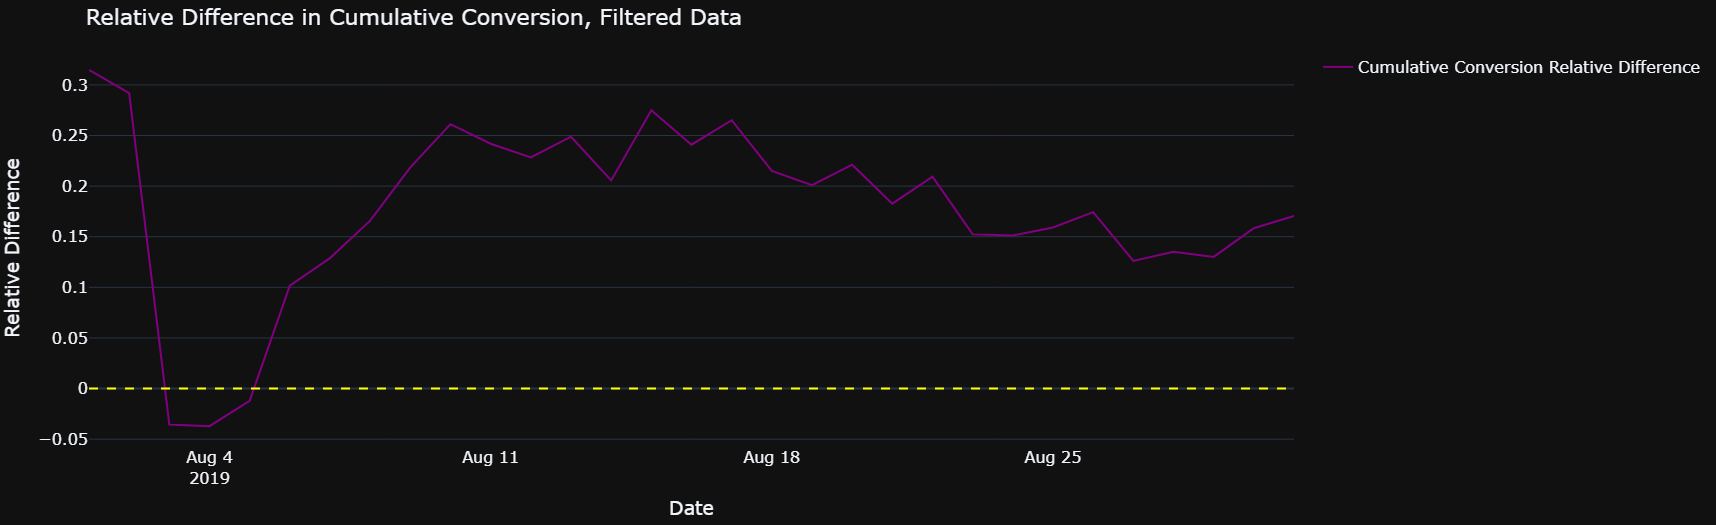

This graph looks quite different than the equivalent raw-data one particularly at the onset of the test, which isn't the most important part. The second half of the graph, towards the end of the month, looks quite similar - a steady decline in the relative difference. It doesn't seem the groups' metrics have stablized yet, and it seems the control group is slowly closing the gap (we could conclude the same by looking at the previous graph, of course). 

Interestingly though, the values of the relative difference at the latter half of the month aren't too different from those we observed with the raw data (in the last week, for example - they are still around 0.15, as they were previously, in the raw data).

All the above being said, we cannot ignore the fact that apart from three days somewhere at the beginning of the test (August 3rd - August 5th) - the test group was always better than the control group in terms of cumulative conversion. 

## Scatter Chart of the Order Sizes - Filtered Data

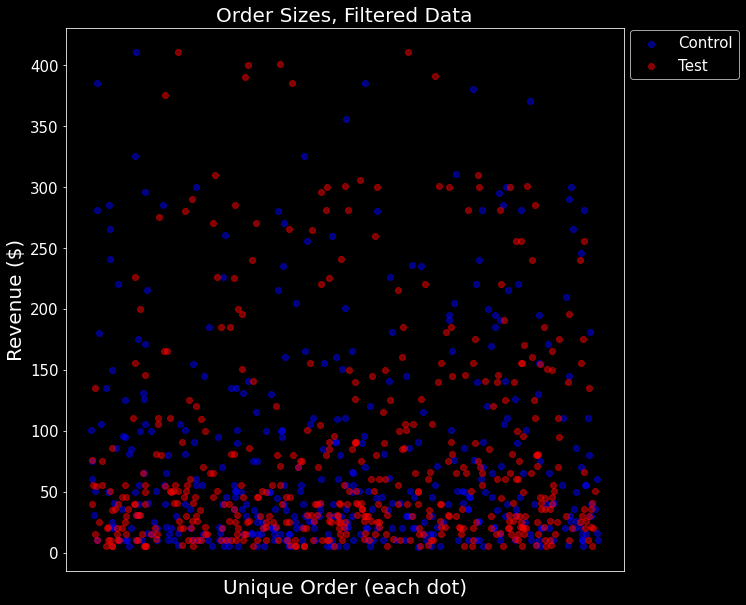

In [72]:
plt.figure(figsize=(10, 10))
plt.scatter(orders_control_filtered['transactionId'], orders_control_filtered['revenue'], label = 'Control', color = 'blue', alpha = 0.5)
plt.scatter(orders_test_filtered['transactionId'], orders_test_filtered['revenue'], label = 'Test', color = 'red', alpha = 0.5)
plt.title('Order Sizes, Filtered Data', fontsize = 20)
plt.xlabel('Unique Order (each dot)', fontsize = 20)
plt.xticks([]) # the ticks of the X axis are irrelevant, so we remove them.
plt.ylabel('Revenue ($)', fontsize = 20)
plt.tick_params(axis='y', labelsize=15)
plt.legend(bbox_to_anchor=(1.22, 1.01), fontsize = 15)

plt.show()

This looks much more normal. More importantly, just by removing the anomalous users, we have also removed the anomalous orders themselves (since they are linked, of course).

## Finding the Statistical Significance of the Difference in Conversion Between the Groups Using the FILTERED Data

The time has come to re-test everything, just like we did before using the raw data, and using the same methods. 

We will do everything exactly the same, but using our filtered data. We will re-create the samples, perform the Z-test as well as the more accurate Mann-Whitney test (if our function determines that is the appropriate test).

Let's go.

In [73]:
# making preparations for the Z-test.
# calculating the total conversions in both groups, using FILTERED data:

# control group:
control_total_buyers_filtered = control_conversion_filtered['buyers'].sum()
control_total_visits_filtered = control_conversion_filtered['visits'].sum()
control_total_conversion_filtered = control_total_buyers_filtered / control_total_visits_filtered

# test group:
test_total_buyers_filtered = test_conversion_filtered['buyers'].sum()
test_total_visits_filtered = test_conversion_filtered['visits'].sum()
test_total_conversion_filtered = test_total_buyers_filtered / test_total_visits_filtered

# printing the results:
print ('Control group: total buyers', control_total_buyers_filtered, ', total visits', control_total_visits_filtered, ', total conversion {:.2%}'.
       format(control_total_conversion_filtered))
print ('Test group: total buyers', test_total_buyers_filtered, ', total visits', test_total_visits_filtered, ', total conversion {:.2%}'.
       format(test_total_conversion_filtered))

Control group: total buyers 406 , total visits 18736 , total conversion 2.17%
Test group: total buyers 481 , total visits 18916 , total conversion 2.54%


Previously, we had a 0.44% difference between the groups. Now we have 0.37%. Is it significant? let's find out.

In [74]:
# performing the Z-test by running our function above:
check_zvalue (control_total_buyers_filtered, control_total_visits_filtered, test_total_buyers_filtered, test_total_visits_filtered)

p-value: 0.01620
Null hypothesis rejected - the proportions are significantly different


Our new p-value has increased to 0.01620 (was 0.00844 previously), but still is less than our alpha (0.05). Meaning - whether we deal with raw or filtered data, the result remains the same - the null hypothesis is REJECTED, the proportions are SIGNIFICANTLY DIFFERENT.

In other words - though a 0.37% may not seem like a lot, according to the Z-test it actually is, seeing as the test led to the conclusion that the proportions are significantly different.

Now, let's prepare the samples for the more accurate test:

In [75]:
control_buyers_list_filtered = orders_filtered[orders_filtered['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
control_buyers_list_filtered.columns = ['visitorId', 'orders']

test_buyers_list_filtered = orders_filtered[orders_filtered['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
test_buyers_list_filtered.columns = ['visitorId', 'orders']

sample_control_filtered = pd.concat([control_buyers_list_filtered['orders'], 
                            pd.Series(0, index=np.arange(control_visits['visits'].sum() - len(control_buyers_list_filtered)), name='orders')],axis=0)

sample_test_filtered = pd.concat([test_buyers_list_filtered['orders'], 
                            pd.Series(0, index=np.arange(test_visits['visits'].sum() - len(test_buyers_list_filtered)), name='orders')],axis=0)

In [76]:
# sanity check: the length of each sample should equal to the total amount of visits of each group:
print (len(sample_control_filtered) == control_visits['visits'].sum())
print (len(sample_test_filtered) == test_visits['visits'].sum())

True
True


And now for the test:

Remember, the null hypothesis we're testing is that the conversion rates of the two groups - with all outliers filtered out - are equal.

The alternative hypothesis is that they are NOT equal.

In [77]:
print ('Average conversion of the control group, filtered data: {:.2%}'.format(sample_control_filtered.mean()))
print ('Average conversion of the test group, filtered data: {:.2%}'.format(sample_test_filtered.mean()))
print ('Relative gain: {:.2%}'.format((sample_test_filtered.mean() / sample_control_filtered.mean()) - 1))
test_hypothesis(sample_control_filtered, sample_test_filtered)

Average conversion of the control group, filtered data: 2.17%
Average conversion of the test group, filtered data: 2.54%
Relative gain: 17.35%
Mann-Whitney test:
p_value: 0.01620
Null hypothesis rejected - the groups have a statistically significant difference


C:\Users\pc\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



Surprisingly (or not?) the Mann-Whitney test and the Z-test yielded exactly the same result. If we compare the new result to the one we achieved using the raw data, we see the relative gain has *increased* a bit (from 15.98% to 17.35%), and the p-value also increased, from 0.01102 to 0.01620, but the null hypothesis is still rejected - the conversion rates are NOT equal. There is a statistically significant difference between them, and undoubtedly the test group performs better than the control group.

## Finding the Statistical Significance of the Difference in Average Order Size Between the Groups Using the FILTERED Data

Time to repeat the test for the average order sizes, using the filtered data.

The null hypothesis is that the average order sizes of the two groups - with the outliers filtered out - are the same.
The alternative hypothesis is that they are NOT the same.

In [78]:
print ('Average order size, control group, filtered data:', orders_control_filtered['revenue'].mean())
print ('Average order size, test group, filtered data:', orders_test_filtered['revenue'].mean())
print ('Relative gain: {:.2%}'.format((orders_test_filtered['revenue'].mean() / orders_control_filtered['revenue'].mean()) - 1))
test_hypothesis(orders_control_filtered['revenue'], orders_test_filtered['revenue'])

Average order size, control group, filtered data: 80.74679802955667
Average order size, test group, filtered data: 78.05821205821198
Relative gain: -3.33%
Mann-Whitney test:
p_value: 0.77119
Failed to reject null hypothesis - the groups MAY NOT have a statistically significant difference


What we see here, first and foremost, is that that the average orders sizes of both groups are VERY similar to one another. Previously they were ~30 USD apart. 
In terms of relative gain, the test group actually performs slightly *worse* than the control group (-3.33%, where previously it was 27.83% thanks to the outliers), but let's not let this negative figure mislead us (more about it in a bit).

Furthermore, the p-value is still quite high (was 0.86223, now 0.77119), so we still fail to reject the null hypothesis, but this time - unlike last time - it makes a lot of sense - we can see the average orders sizes are more or less the same, So it is only natural to expect the null hypothesis to not be rejected.

Formally speaking, the test suggests that, with the anomalies taken out, there is no statistically significant difference between the two groups.

As for the fact that we have a slightly lower average order size in the test group. This alone might seem bad, but let's not forget something extremely important: we have seen that the test group's conversion is ~17% HIGHER than that of the control group. If we think of the two average order sizes as "the same" (a difference of ~2.5 USD isn't much, and we have just proved that), it turns out that *overall, the test group attracts more users to make a purchase, and on average, they make the same purchases as the users in the control group.* In other words - *we get "more of the same"* with the test group. 

Ultimately - the test group attracts more buyers, AND generates more revenue (we also saw that in the graphs). 

Isn't that considered a great success?

# Decisions Based on the Results

When the raw data was analyzed, it seemed like the test group showed a major advantage over the control group in terms of cumulative revenue, conversion, and average order size. However, we soon found out that the test group had a few "big fish" among its members, skewing the data heavily to its favor.

Once removing the outliers from both groups (after checking for the typical behaviour of all users in terms of number of orders and order sizes), we have analyzed all the metrics again. These are the bottom lines:

1) The test group showed an increase of 17.35% in conversion over the control group. The test group is the clear winner.

2) Cumulative Revenue: this is the only metric in which the test group showed a steady and increasing advantage over the control group, even after the removal of the outliers. As the test progressed, the difference in the cumulative revenues of the two groups became larger. The test group is the clear winner in that regard as well.

3) Average Order Size: this one was quite tricky. For the entire duration of the test, the two groups alternated in leading the chart, with each group surpassing the other for a certain amount of time, before the other group surpassed it back. By the end of the test both groups have reached a point of nearly-identical cumulative order sizes. In this regard, there is no clear leader among the groups.

Overall, it would seem that the test group is the leader in performance over the control group, at least in two out of three metrics (the third one being tied). What we see is a substantial increase in conversion with the test group, while the average order size remains approximately the same (though slightly lower than the control group). The math is simple in this case - the test group had more individuals converting and generating, on average, the same revenue as the converted users of the control group, resulting in an overall greater revenue. This alone could be considered worth the application of the change presented to the test group, assuming the costs don't outweigh the benefits, as it clearly leads to more paying customers. 

Thus, the recommendation is for the test to be stopped (considered a success!), and the tested changes to the product/website - **applied.**